In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load all 9 merged DataFrames
tr_data_df = pd.read_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/tr_data_df.csv")
val_data_df = pd.read_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/val_data_df.csv")
te_data_df = pd.read_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/te_data_df.csv")

tr_data_df_b = pd.read_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/tr_data_df_b.csv")
val_data_df_b = pd.read_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/val_data_df_b.csv")
te_data_df_b = pd.read_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/te_data_df_b.csv")

tr_data_df_j = pd.read_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/tr_data_df_j.csv")
val_data_df_j = pd.read_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/val_data_df_j.csv")
te_data_df_j = pd.read_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/te_data_df_j.csv")

### Preprocessing of Final Dataframe
To prepare the data as best as possible for machine learning algorithms and regularization, we need to clean and encode/transform our features. As we have now finished the merging process and have thus created our feature space, we will start with detecting and cleaning outliers in the **continuous variables**. This is now possible because we have structured our features around the combination of unique students and assessments.

#### Features to be log-transformed
All following continuous features can benefit from being centered more, so they will be log-transformed.

Some of the features may seem categorial when visualized, but this is because we only have a limited number of observations available in this instance, e.g. `module_presentation_length` or `date`. In theory, however, all numbers (lenghts, assessment/submission dates etc.) are possible. Therefore, these features will be log-transformed to center them.

* `date_submitted` --> captures the date (day relative to presentation start) of assessment submission; the dates here are supposed to represent a natural order
* `score` marks the assessment scores from 0 to 100; scores should definitely reflect the natural ranking order
* `date` --> represents the date of the assessment; stands in direct relation to `date_submitted`
* `module_presentation_length`--> counts the length of the module
* `weight` --> represents the weight of the exam towards the final result. This could also be viewed as a categorical variable, but to me it makes sense to attribute a ranking to these weights since student ought to/might take exams more seriously if they're weighted more. Therefore, I keep the natural encoding order of numbers from 0 to 100
* `total_sites_used` --> counts the number of different resources used per student per course (_not_ unique to assessments); has a clear ranking from fewer to more sites used, so will stay in the count format from 0 upwards
* `total_clicks` --> counts the number of clicks a student does in total, i.e. across all sites; has a clear order from little VLE usage to high usage in number format starting from 0
* `avg_working_dates` --> on what day, relative to presentation start, the student was active in the VLE; counts the number of days from 0 onwards and averages it, so it is supposed to represent a trend of lower or higher values

We will start with a visualization of the current state of distribution.

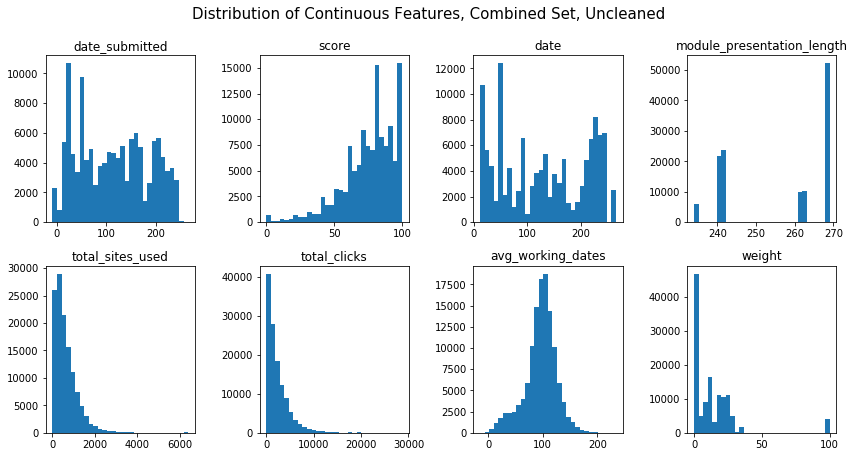

In [3]:
# group continuous features
cont_features = ["date_submitted", "score", "date", "module_presentation_length", "total_sites_used",
                 "total_clicks", "avg_working_dates", "weight"]

# visualize distribution of train set with histograms
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for ftr, ax in zip(cont_features, axs.flat):
    ax.hist(tr_data_df[ftr], bins = 30)
    ax.set_title(ftr)
    
fig.suptitle("Distribution of Continuous Features, Combined Set, Uncleaned", size = 15, y = 1.05)
plt.tight_layout() # avoids overlapping labels
plt.show()

In [4]:
# get numerical overview of data before cleaning
tr_data_df[cont_features].describe()

,date_submitted,score,date,module_presentation_length,total_sites_used,total_clicks,avg_working_dates,weight
count,124214.000000,124214.000000,124214.000000,124214.000000,124214.00000,124214.000000,124214.000000,124214.000000
mean,114.330373,75.374612,130.745600,255.409712,637.75283,2413.103925,96.094688,13.417908
std,71.855392,19.050918,79.346524,13.522458,553.33975,2503.532895,29.187367,18.625183
min,-9.000000,0.000000,12.000000,234.000000,1.00000,1.000000,-15.000000,0.000000
25%,49.000000,65.000000,53.000000,241.000000,246.00000,715.000000,82.533769,0.000000
50%,114.000000,79.000000,129.000000,262.000000,488.00000,1626.000000,99.222222,10.000000
75%,172.000000,89.000000,214.000000,268.000000,870.00000,3286.000000,113.430435,20.000000
max,266.000000,100.000000,265.000000,269.000000,6389.00000,28615.000000,234.000000,100.000000


In [5]:
print("number of weight = 0 observations:", len(tr_data_df.loc[tr_data_df["weight"] == 0, :]))
print("number of total_sites_used = 0 observations:", len(tr_data_df.loc[
    tr_data_df["total_sites_used"] == 0, :]))
print("number of total_clicks = 0 observations:", len(tr_data_df.loc[tr_data_df["total_clicks"] == 0, :]))

# check whether weight == 0 assessments have valid scores, then they're probably preparation exams
tr_data_df.loc[tr_data_df["id_assessment"] == 34906, ["score", "id_assessment", "weight"]][:5]

number of weight = 0 observations: 31178
number of total_sites_used = 0 observations: 0
number of total_clicks = 0 observations: 0


,score,id_assessment,weight
1408,57,34906,0.0
1416,57,34906,0.0
10475,71,34906,0.0
10493,71,34906,0.0
10511,71,34906,0.0


We can see that all features beside `avg_working_dates` are either very spread out and/or skewed towards one end. 

To correct for this, we are first going to log-transform the data in order to center it, then apply z-scaling to make the distribution comparable. After that, we will check for outliers above 3 standard deviations away from the mean, and then clean these >3 std values. 

`weight` has a lot of 0-weighted assessments, which are probably mock assessments during preparation because of valid assessment scores. As this is a very distinct, standalone sub-population, I will detect and clean outliers separately while excluding zeros.

Regarding `total_sites_used` and `total_clicks`: It only looks like there are many 0 observations due to bin size, but as we explicitly checked above, there are none.

It is important to note that we have negative values in two of the above columns: `date_submitted` and `avg_working_dates`. As a consequence, these values would create errors in our log-transformation because the logarithm of negative values isn't defined. Therefore, we need to add a constant to these values - derived from the logic of `np.log1p()`. The problem with `np.log1p()` is that it only adds $\log{(1 + \text{observation})}$, but our train set values go as far back as 15 days before presentation start. As we can't look at values from the validation and test set, I will assume that no submission or mean of working days is more than 30 days in advance of presentation start. We know that module registration are partially very early (> 200 days), however we have no information about how early submissions can start. Because of this, I will incorporate a buffer range of 2x what we observed in the train set. Consequently, this 2x range results in exactly one month, which in my view is realistic to assume that no student submits assessments or has his average of work load one month before presentations start.

Adding a constant of 30 to each feature may first sound like much, but when we consider that the smallest distribution scale is 100 (`weight`, `score`), other features are on a ~300 scale(`date_submitted`, `date`, `avg_working_dates`, `module_presentation_length`), and some features even on a ~6.000 (`total_sites_used`) and ~30.000 scale (`total_clicks`), the 30 doesn't change the distribution too much. Furthermore, when cleaning values we will also apply z-scaling beforehand to have every feature centered around $\text{mean} = 0, \text{std} = 1$.

Following this preprocessing, we have to be aware that we can't just add the constant to these two features as they are logically dependent on other continuous features. For instance, `date_submission`, `date`, and `avg_working_date` all track the same amound of days starting from day 0 of presentation start. In other cases where the scaling is different (before z-scaling), it is still important to add the constant to have equal transformation effects when logarithm is applied.

In [6]:
# find lowest value in combined set
print("lowest value in combined set in either date_submitted or avg_working_dates:", min(
    tr_data_df["avg_working_dates"].min(), tr_data_df["date_submitted"].min()))

# B term
print("lowest value in B term set in either date_submitted or avg_working_dates:", min(
    tr_data_df_b["avg_working_dates"].min(), tr_data_df_b["date_submitted"].min()))

# J term
print("lowest value in J term set in either date_submitted or avg_working_dates:", min(
    tr_data_df_j["avg_working_dates"].min(), tr_data_df_j["date_submitted"].min()))

lowest value in combined set in either date_submitted or avg_working_dates: -15.0
lowest value in B term set in either date_submitted or avg_working_dates: -11.0
lowest value in J term set in either date_submitted or avg_working_dates: -15.0


In [7]:
# group all continuous variables in separate df
cont_df = tr_data_df[cont_features].copy()

# define log-transformation function
def log30p(obs):
    return np.log(30 + obs) # add constant of 30 to every observation

# replace 0 values with NaN in weight
cont_df.replace(to_replace = 0, value = {"weight": np.nan}, inplace = True)

# log transform all continuous features
cont_df_log = cont_df.applymap(log30p) # applymap applies a function to every value in df and returns scalar
                     
# create a z-scaling function that ignores NaN values
def z_score(col):
    mean = col.mean()
    std = col.std()
    return ((col - mean) / std)

# calculate z-scores of every column, zeros in weight column get ignored as they are NaNs
cont_df_log_z = cont_df_log.apply(z_score, axis = 0) # apply function to each col along axis 0

# check whether scaling worked
print("Mean should now be 0:", cont_df_log_z["score"].mean()) # exemplary column
print("Std should now be 1:", cont_df_log_z["total_sites_used"].std()) # exemplary column

Mean should now be 0: 1.2975953932714599e-15
Std should now be 1: 1.0


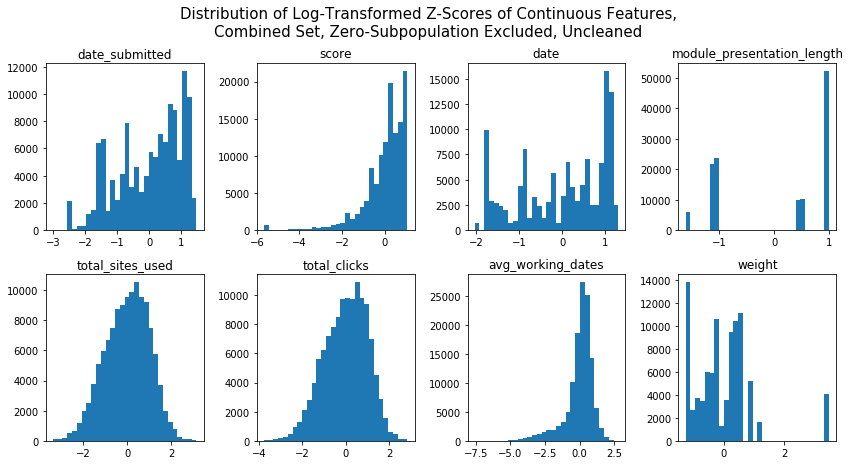

In [8]:
# visualize results of log-transformation and z-scaling
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for ftr, ax in zip(cont_features, axs.flat):
    ax.hist(cont_df_log_z[ftr][~np.isnan(cont_df_log_z[ftr])], # get all non-NaN values
            bins = 30)
    ax.set_title(ftr)
    
fig.suptitle("Distribution of Log-Transformed Z-Scores of Continuous Features,\nCombined Set, Zero-Subpopulation Excluded, Uncleaned",
             size = 15, y = 1.07)
plt.tight_layout() # avoids overlapping labels
plt.show()

We can see that some features have been well centered by applying log-transformation, e.g. `total_sites_used` and `total_clicks`. `avg_working_dates` was already Gaussian-like, so there isn't any huge transformation. `module_presentation_length` and `weight` are still spread out, whereas `date_submitted` and `date` are slightly more centered.

Due to z-sclaing we can see, however, that there are many outliers above/below 3 standard units, for instance in `avg_working_dates`, `score` and `total_clicks`. 

I will now detect and drop all outliers as defined as values above/below 3 standard units. 

In [9]:
# get absolute values of every observation, filter for values greater than 3
print("observations to drop in total:", (np.abs(cont_df_log_z) > 3).sum().sum())

# specified by feature
(np.abs(cont_df_log_z) > 3).sum()

observations to drop in total: 9765


date_submitted                   1
score                         2376
date                             0
module_presentation_length       0
total_sites_used               256
total_clicks                   341
avg_working_dates             2751
weight                        4040
dtype: int64

In [10]:
# get shape before drops
print("tr_data_df shape before cleaning", tr_data_df.shape)

# get indices of these values, drop indices in our tr_data_df    
for col in cont_features:
    # get indices to drop for each column in a variable for each loop
    index_to_drop = cont_df_log_z.loc[np.abs(cont_df_log_z[col]) > 3].index
    
    # drop the indices in our tr_data_df
    # ignore errors when labels don't exist, i.e. value has already been dropped in a previous rotation
    tr_data_df.drop(index = index_to_drop, inplace = True, errors = "ignore")

print("tr_data_df shape after drops:", tr_data_df.shape)

tr_data_df shape before cleaning (124214, 27)
tr_data_df shape after drops: (115027, 27)


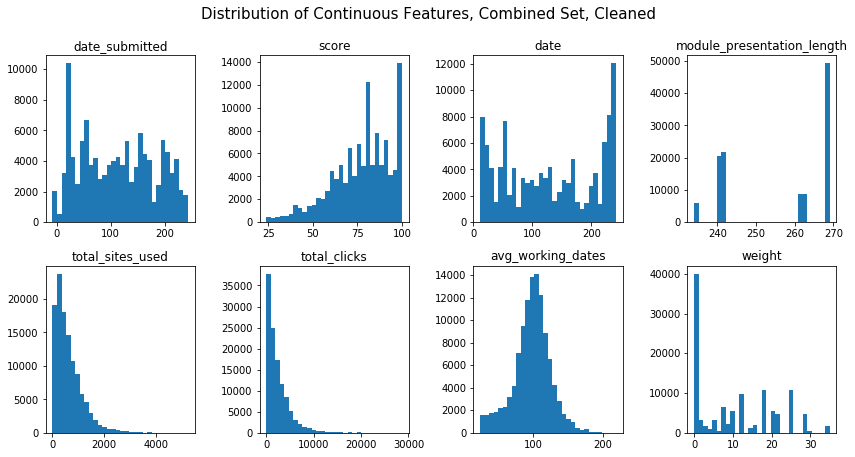

In [11]:
# visualize cleaned results, here non-log-transformed
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for ftr, ax in zip(tr_data_df[cont_features], axs.flat):
    ax.hist(tr_data_df[ftr], bins = 30)
    ax.set_title(ftr)
    
fig.suptitle("Distribution of Continuous Features, Combined Set, Cleaned", size = 15, y = 1.05)
plt.tight_layout() # avoids overlapping labels
plt.show()

In these non-log-transformed values, we can see that `total_sites_used` and `total_clicks` are still very left-skewed. However, when log-transformed and z-scaled, we saw that only 256 and 341 values, respectively, were above 3 standard units and thus dropped. 

In the next plot, I will visualize the log-transformed, cleaned continuous features. For the ML models, we will use these log-transformed values.

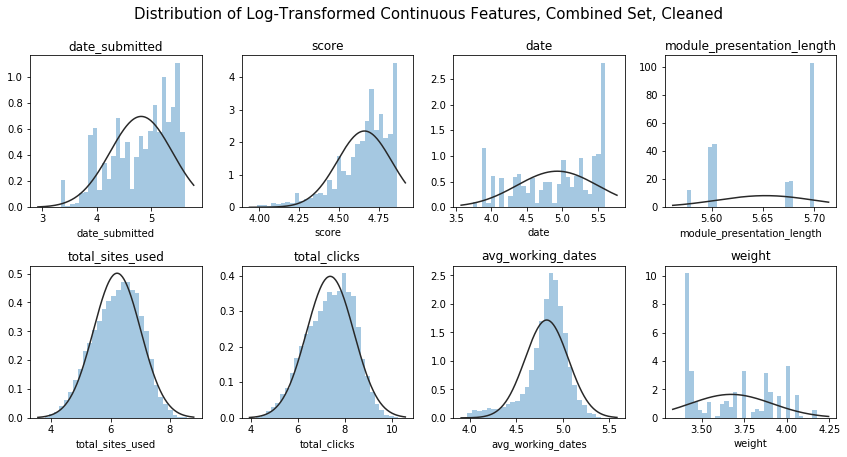

In [12]:
# visualize cleaned results, here log-transformed
from scipy.stats import norm

cont_features_cleaned = tr_data_df[cont_features]

cont_features_log_cleaned = cont_features_cleaned.applymap(log30p)

# plot results
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for col, ax in zip(cont_features_log_cleaned, axes.flat):
    # plot Gaussian curve on top of transformed features to see difference to normal distribution
    ax = sns.distplot(cont_features_log_cleaned[col], bins = 30, hist = True, kde = False,
                      fit = norm, ax = ax)
    ax.set_title(col)

fig.suptitle("Distribution of Log-Transformed Continuous Features, Combined Set, Cleaned",
             y = 1.05, size = 15)
fig.tight_layout() # avoids overlapping labels
plt.show()

Especially our three engineered features are now extremely nicely centered. The features `date_submitted`, `score`, `date` and `weight` are now also more centered and condensed, which is preferable for ML algorithms, but still they still have spikes around certain dates/scores/weights. `module_presentation_length` is in this case still very spread out, which is due to its low number of observed values. Nevertheless, it is still more centered.

Log-transformation isn't the only available possibility to transform and thus center our features. I will now also try an sqrt-transformation.

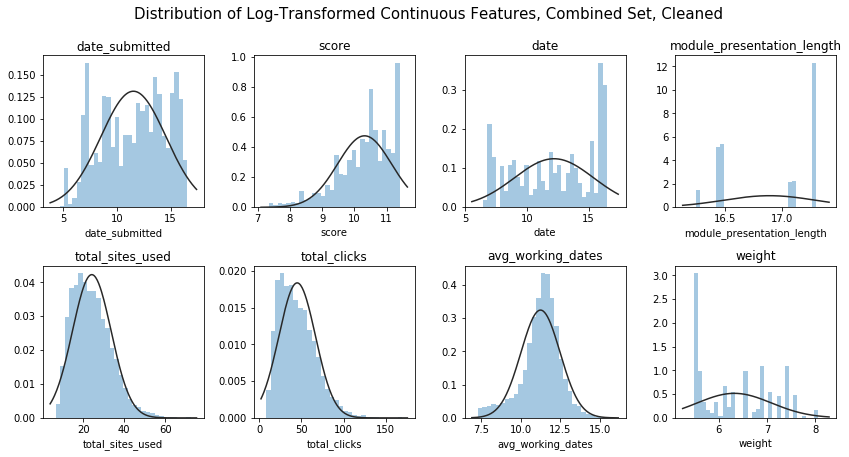

In [13]:
# try sqrt-transformation

# we also have to add a constant here
def sqrt30p(obs):
    return np.sqrt(30 + obs)

cont_features_cleaned_test = tr_data_df[cont_features]

cont_features_sqrt_cleaned = cont_features_cleaned_test.applymap(sqrt30p)

# plot results
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for col, ax in zip(cont_features_sqrt_cleaned, axes.flat):
    # plot Gaussian curve on top of transformed features to see difference to normal distribution
    ax = sns.distplot(cont_features_sqrt_cleaned[col], bins = 30, hist = True, kde = False,
                      fit = norm, ax = ax)
    ax.set_title(col)

fig.suptitle("Distribution of Log-Transformed Continuous Features, Combined Set, Cleaned",
             y = 1.05, size = 15)
fig.tight_layout() # avoids overlapping labels
plt.show()

In [14]:
# show final descriptive analysis of cleaned values
tr_data_df[cont_features].describe()

,date_submitted,score,date,module_presentation_length,total_sites_used,total_clicks,avg_working_dates,weight
count,115027.000000,115027.000000,115027.000000,115027.000000,115027.000000,115027.000000,115027.000000,115027.000000
mean,112.394803,77.152477,129.133412,255.411051,645.417241,2460.789536,98.099384,10.569119
std,68.744292,16.667112,76.700527,13.592752,539.271826,2472.640390,26.754646,9.974571
min,-8.000000,24.000000,12.000000,234.000000,14.000000,40.000000,23.201220,0.000000
25%,51.000000,67.000000,54.000000,241.000000,255.000000,747.000000,84.316611,0.000000
50%,112.000000,80.000000,124.000000,262.000000,500.000000,1695.000000,99.901693,9.000000
75%,168.000000,90.000000,208.000000,268.000000,885.000000,3360.000000,113.970186,18.000000
max,243.000000,100.000000,241.000000,269.000000,5240.000000,28615.000000,218.882353,35.000000


The results with an sqrt-transformation look worse compared to log-transformed features. `total_sites_used`, `total_clicks`, and `date_submitted` look particularly worse centered here than in the log-transformation. The other features look comparable. As especially `total_sites_used` and `total_clicks` looked very well centered and fitted to the Gaussian curve, I will choose the log-transformation for the feature encoding/transformation step.

Additionally, we can see in the descriptive statistics that the standard deviation has shrunk, which is a good indicator that data cleaning has dropped outliers, which enables the models to train and create more robust coefficients.

I will now repeat the cleaning steps now for the separate B and J term sets.

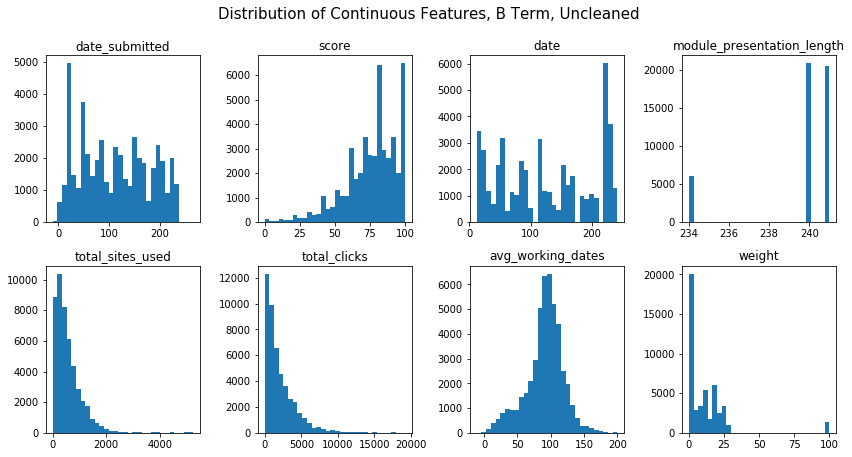

In [15]:
# B term
# visualize distribution of train set with histograms
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for ftr, ax in zip(cont_features, axs.flat):
    ax.hist(tr_data_df_b[ftr], bins = 30)
    ax.set_title(ftr)
    
fig.suptitle("Distribution of Continuous Features, B Term, Uncleaned", size = 15, y = 1.05)
plt.tight_layout() # avoids overlapping labels
plt.show()

In [16]:
# get numerical overview of data before cleaning
tr_data_df_b[cont_features].describe()

,date_submitted,score,date,module_presentation_length,total_sites_used,total_clicks,avg_working_dates,weight
count,47508.000000,47508.000000,47508.000000,47508.000000,47508.000000,47508.000000,47508.000000,47508.000000
mean,112.129368,75.663572,125.518334,239.657931,577.202576,2148.038920,90.794451,11.509083
std,68.212517,18.822625,74.914460,2.225788,508.085024,2220.704637,27.952842,17.259789
min,-11.000000,0.000000,12.000000,234.000000,1.000000,1.000000,-11.000000,0.000000
25%,51.000000,65.000000,53.000000,240.000000,225.000000,618.000000,78.309375,1.000000
50%,114.000000,80.000000,117.000000,240.000000,444.000000,1405.000000,93.730769,7.500000
75%,168.000000,90.000000,206.000000,241.000000,781.000000,2920.000000,107.879686,18.000000
max,266.000000,100.000000,241.000000,241.000000,5240.000000,19196.000000,199.696296,100.000000


The B term data is distributed very similarly to the combined set. The only real difference is the `module_presentation_length` because the modules are all shorter than the J term. Furthermore, the value range is shorter here: `total_clicks` 'only' ranges to 20.000 at max, and `total_sites_used` isn't spread out to 6.000, but only to around 5.000. 

We will apply the same preprocessing here with our own created `log30p` function. In the end, we will also test the `sqrt30p` transformation as a comparison.

In [17]:
# group all continuous variables in separate df
cont_df_b = tr_data_df_b[cont_features].copy()

# replace 0 values with NaN in weight
cont_df_b.replace(to_replace = 0, value = {"weight": np.nan}, inplace = True)

# log transform all continuous features
cont_df_log_b = cont_df_b.applymap(log30p) # applymap applies a function to every df value, returns scalar

# calculate z-scores of every column, zeros in weight column get ignored as they are NaNs
cont_df_log_z_b = cont_df_log_b.apply(z_score, axis = 0) # apply function to each col along axis 0

# check whether scaling worked
print("Mean should now be 0:", cont_df_log_z_b["weight"].mean()) # exemplary column
print("Std should now be 1:", cont_df_log_z_b["total_clicks"].std()) # exemplary column

Mean should now be 0: 6.518384732577778e-16
Std should now be 1: 0.9999999999999998


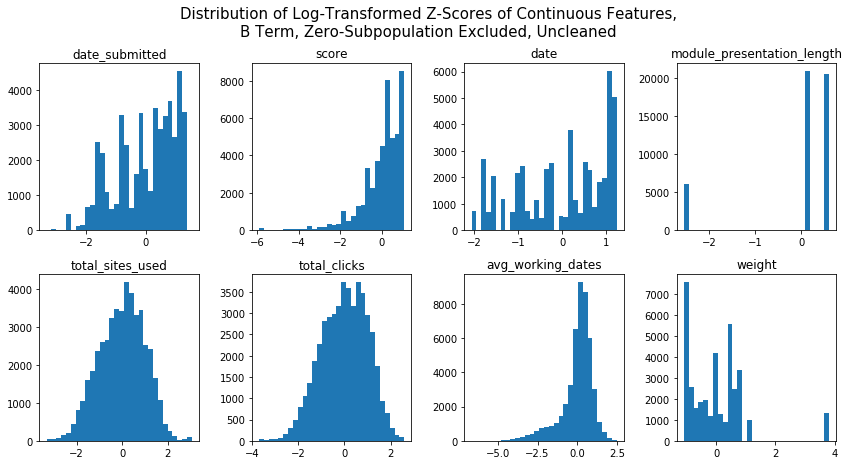

In [18]:
# visualize results of log-transformation and z-scaling
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for ftr, ax in zip(cont_features, axs.flat):
    ax.hist(cont_df_log_z_b[ftr][~np.isnan(cont_df_log_z_b[ftr])], # get all non-NaN values
            bins = 30)
    ax.set_title(ftr)
    
fig.suptitle("Distribution of Log-Transformed Z-Scores of Continuous Features,\nB Term, Zero-Subpopulation Excluded, Uncleaned",
             size = 15, y = 1.07)
plt.tight_layout() # avoids overlapping labels
plt.show()

`total_sites_used`, `total_clicks` as well as `avg_working_dates` are again very well centered. All other features roughly mirror the distribution of the combined term. `module_presentation_length` is again the outlier here because there are only very few possible values given.

I will now detect and drop all outliers as defined as values above/below 3 standard units. 

In [19]:
# get absolute values of every observation, filter for values greater than 3
print("observations to drop in total:", (np.abs(cont_df_log_z_b) > 3).sum().sum())

# specified by feature
(np.abs(cont_df_log_z_b) > 3).sum()

observations to drop in total: 3438


date_submitted                  24
score                          912
date                             0
module_presentation_length       0
total_sites_used               136
total_clicks                   106
avg_working_dates              955
weight                        1305
dtype: int64

In [20]:
# get shape before drops
print("tr_data_df_b shape before cleaning", tr_data_df_b.shape)

# get indices of these values, drop indices in our tr_data_df    
for col in cont_features:
    # get indices to drop for each column in a variable for each loop
    index_to_drop = cont_df_log_z_b.loc[np.abs(cont_df_log_z_b[col]) > 3].index
    
    # drop the indices in our tr_data_df
    # ignore errors when labels don't exist, i.e. value has already been dropped in a previous rotation
    tr_data_df_b.drop(index = index_to_drop, inplace = True, errors = "ignore")

print("tr_data_df_b shape after drops:", tr_data_df_b.shape)

tr_data_df_b shape before cleaning (47508, 27)
tr_data_df_b shape after drops: (44295, 27)


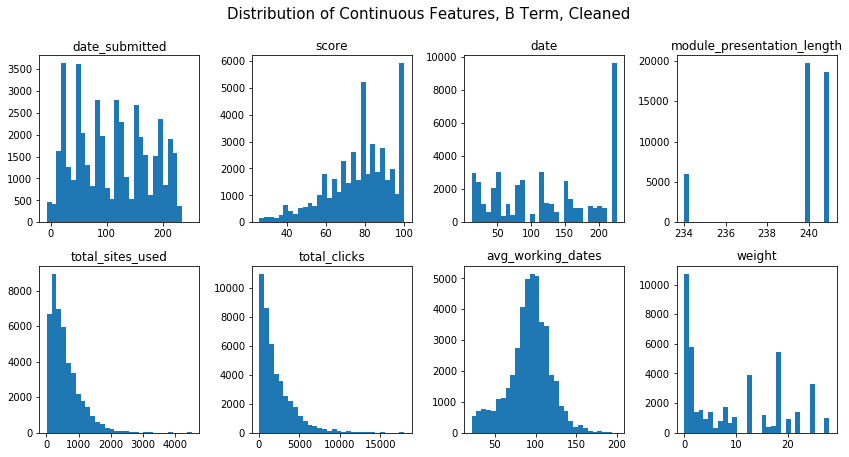

In [21]:
# visualize cleaned results, here non-log-transformed
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for ftr, ax in zip(tr_data_df_b[cont_features], axs.flat):
    ax.hist(tr_data_df_b[ftr], bins = 30)
    ax.set_title(ftr)
    
fig.suptitle("Distribution of Continuous Features, B Term, Cleaned", size = 15, y = 1.05)
plt.tight_layout() # avoids overlapping labels
plt.show()

In these non-log-transformed values, we can see that `total_sites_used` and `total_clicks` are still very left-skewed. However, when log-transformed and z-scaled, we saw that only 136 and 106 values, respectively, were above 3 standard units and thus dropped.

In general, the visualization here is very alike to the combined set - which makes sense as it was a significant part of it.

In the next plot, I will visualize the log-transformed, cleaned continuous features. For the ML models, we will use these log-transformed values.

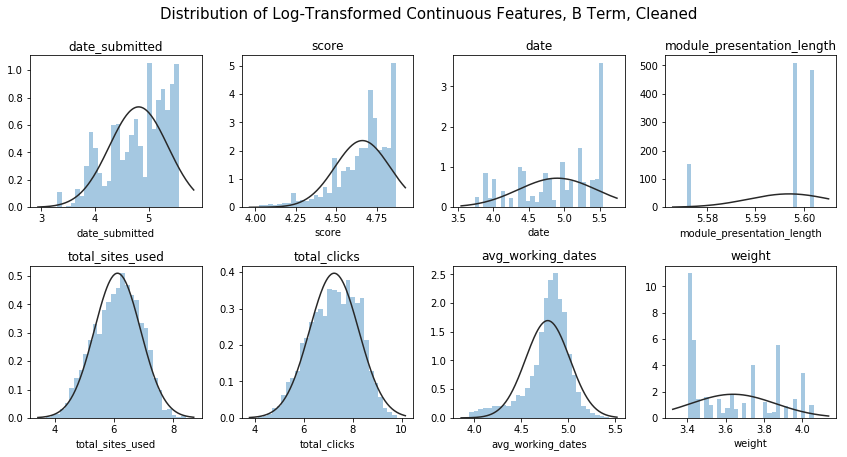

In [22]:
# B term
# visualize cleaned results, here log-transformed

cont_features_cleaned_b = tr_data_df_b[cont_features]

cont_features_log_cleaned_b = cont_features_cleaned_b.applymap(log30p)

# plot results
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for col, ax in zip(cont_features_log_cleaned_b, axes.flat):
    # plot Gaussian curve on top of transformed features to see difference to normal distribution
    ax = sns.distplot(cont_features_log_cleaned_b[col], bins = 30, hist = True, kde = False,
                      fit = norm, ax = ax)
    ax.set_title(col)

fig.suptitle("Distribution of Log-Transformed Continuous Features, B Term, Cleaned",
             y = 1.05, size = 15)
fig.tight_layout() # avoids overlapping labels
plt.show()

Our three engineered features are again very nicely centered. The features `date_submitted`, `score`, `date` and `weight` are now also more centered and condensed. `module_presentation_length` is in again spread out, which is due to the low variety of observations.

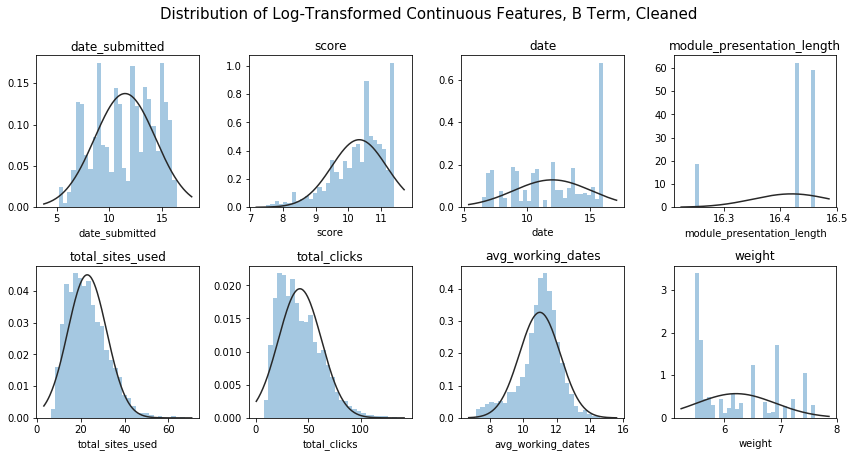

In [23]:
# B term
# try sqrt-transformation

cont_features_cleaned_test_b = tr_data_df_b[cont_features]

cont_features_sqrt_cleaned_b = cont_features_cleaned_test_b.applymap(sqrt30p)

# plot results
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for col, ax in zip(cont_features_sqrt_cleaned_b, axes.flat):
    # plot Gaussian curve on top of transformed features to see difference to normal distribution
    ax = sns.distplot(cont_features_sqrt_cleaned_b[col], bins = 30, hist = True, kde = False,
                      fit = norm, ax = ax)
    ax.set_title(col)

fig.suptitle("Distribution of Log-Transformed Continuous Features, B Term, Cleaned",
             y = 1.05, size = 15)
fig.tight_layout() # avoids overlapping labels
plt.show()

In [24]:
# show final descriptive analysis of cleaned values
tr_data_df_b[cont_features].describe()

,date_submitted,score,date,module_presentation_length,total_sites_used,total_clicks,avg_working_dates,weight
count,44295.000000,44295.000000,44295.000000,44295.000000,44295.000000,44295.000000,44295.000000,44295.000000
mean,110.410227,77.320465,124.166068,239.616955,578.808308,2170.740964,92.520498,9.008601
std,65.609744,16.683339,73.030647,2.258680,478.807225,2154.037171,25.946460,8.940987
min,-7.000000,26.000000,12.000000,234.000000,11.000000,33.000000,21.588235,0.000000
25%,52.000000,67.000000,53.000000,240.000000,232.000000,638.000000,79.691489,1.000000
50%,112.000000,80.000000,117.000000,240.000000,452.000000,1445.000000,94.411590,7.000000
75%,164.000000,90.000000,200.000000,241.000000,790.000000,3004.000000,108.361463,18.000000
max,252.000000,100.000000,227.000000,241.000000,4518.000000,17957.000000,199.696296,28.000000


Because `total_sites_used` and `total_clicks` here again look worse fitted to the Gaussian curve than in the log-transformation, I will stick with the transformation choice of the combined model and thus choose log-transformation again. 

As with the combined model, we can see in the descriptive statistics that the standard deviation has shrunk across all features, which shows us that the cleaning process was successful.

I will now repeat the cleaning steps again for the J term sets.

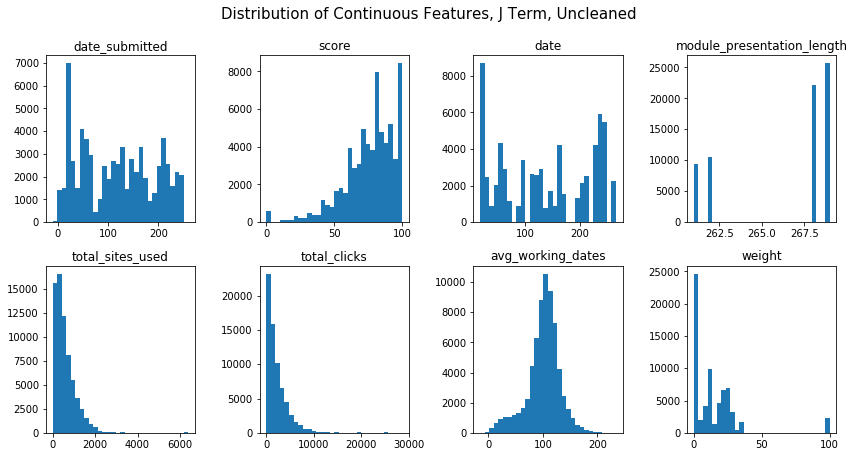

In [25]:
# visualize distribution of train set with histograms
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for ftr, ax in zip(cont_features, axs.flat):
    ax.hist(tr_data_df_j[ftr], bins = 30)
    ax.set_title(ftr)
    
fig.suptitle("Distribution of Continuous Features, J Term, Uncleaned", size = 15, y = 1.05)
plt.tight_layout() # avoids overlapping labels
plt.show()

In [26]:
# get numerical overview of data before cleaning
tr_data_df_j[cont_features].describe()

,date_submitted,score,date,module_presentation_length,total_sites_used,total_clicks,avg_working_dates,weight
count,67761.000000,67761.000000,67761.000000,67761.000000,67761.000000,67761.000000,67761.000000,67761.000000
mean,117.612137,75.707029,135.770901,266.474609,588.517850,2255.294624,100.928906,14.220569
std,73.587974,18.928983,81.774828,3.232072,507.872493,2334.444419,30.211901,18.934361
min,-10.000000,0.000000,18.000000,261.000000,1.000000,1.000000,-15.000000,0.000000
25%,51.000000,65.000000,54.000000,262.000000,229.000000,684.000000,87.805755,0.000000
50%,118.000000,80.000000,131.000000,268.000000,453.000000,1525.000000,104.341902,10.000000
75%,178.000000,90.000000,229.000000,269.000000,799.000000,3071.000000,118.604072,20.000000
max,259.000000,100.000000,265.000000,269.000000,6389.000000,28615.000000,234.000000,100.000000


The values here resemble even stronger the combined set. This is because the J term contributes more observations than the B term to the combined set. For instance, `total_clicks` range again up to 30.000, `total_sites_used` range again above 6.000.

I will again apply the self defined `log30p` transformation and test it against the `sqrt30p` transformation.

In [27]:
# group all continuous variables in separate df
cont_df_j = tr_data_df_j[cont_features].copy()

# replace 0 values with NaN in weight
cont_df_j.replace(to_replace = 0, value = {"weight": np.nan}, inplace = True)

# log transform all continuous features
cont_df_log_j = cont_df_j.applymap(log30p) # applymap applies a function to every df value, returns scalar

# calculate z-scores of every column, zeros in weight column get ignored as they are NaNs
cont_df_log_z_j = cont_df_log_j.apply(z_score, axis = 0) # apply function to each col along axis 0

# check whether scaling worked
print("Mean should now be 0:", cont_df_log_z_j["total_sites_used"].mean()) # exemplary column
print("Std should now be 1:", cont_df_log_z_j["avg_working_dates"].std()) # exemplary column

Mean should now be 0: 8.828174454869739e-16
Std should now be 1: 0.9999999999999999


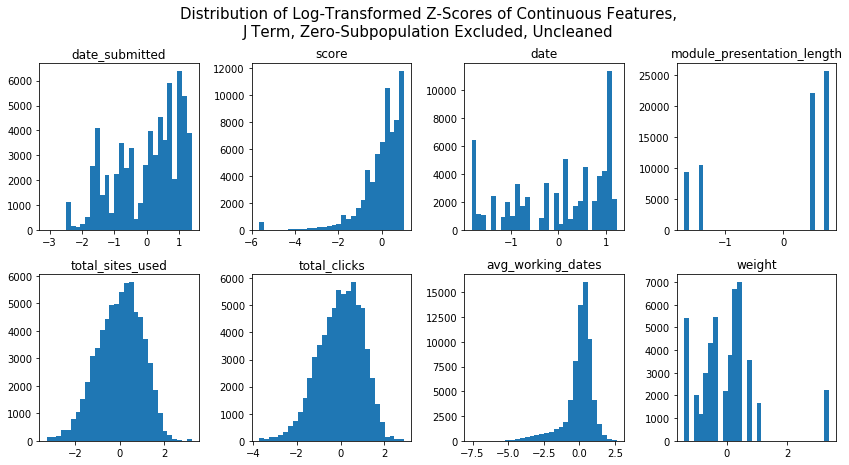

In [28]:
# visualize results of log-transformation and z-scaling
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for ftr, ax in zip(cont_features, axs.flat):
    ax.hist(cont_df_log_z_j[ftr][~np.isnan(cont_df_log_z_j[ftr])], # get all non-NaN values
            bins = 30)
    ax.set_title(ftr)
    
fig.suptitle("Distribution of Log-Transformed Z-Scores of Continuous Features,\nJ Term, Zero-Subpopulation Excluded, Uncleaned",
             size = 15, y = 1.07)
plt.tight_layout() # avoids overlapping labels
plt.show()

As in the combined sets, we can see that we have many outliers above/below 3 standard units, for instance in `avg_working_dates`, `score` and `date_submitted`. These will again be dropped. 

Additionally, we can observer here again that the J term set is the driving force of the combined set. The distributions look extremely similar across all features. The exception here is again `module_presentation_length` because the combined set has all variations of both B and J term set available.

I will now detect and drop all outliers as defined as values above/below 3 standard units. 

In [29]:
# get absolute values of every observation, filter for values greater than 3
print("observations to drop in total:", (np.abs(cont_df_log_z_j) > 3).sum().sum())

# specified by feature
(np.abs(cont_df_log_z_j) > 3).sum()

observations to drop in total: 5747


date_submitted                   1
score                         1280
date                             0
module_presentation_length       0
total_sites_used               220
total_clicks                   308
avg_working_dates             1698
weight                        2240
dtype: int64

In [30]:
# get shape before drops
print("tr_data_df_j shape before cleaning", tr_data_df_j.shape)

# get indices of these values, drop indices in our tr_data_df    
for col in cont_features:
    # get indices to drop for each column in a variable for each loop
    index_to_drop = cont_df_log_z_j.loc[np.abs(cont_df_log_z_j[col]) > 3].index
    
    # drop the indices in our tr_data_df
    # ignore errors when labels don't exist, i.e. value has already been dropped in a previous rotation
    tr_data_df_j.drop(index = index_to_drop, inplace = True, errors = "ignore")

print("tr_data_df_j shape after drops:", tr_data_df_j.shape)

tr_data_df_j shape before cleaning (67761, 27)
tr_data_df_j shape after drops: (62447, 27)


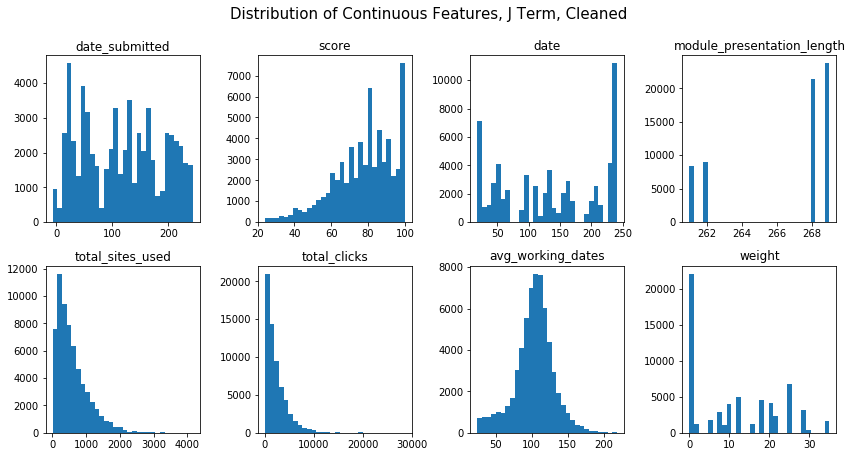

In [31]:
# J term
# visualize cleaned results, here non-log-transformed
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for ftr, ax in zip(tr_data_df_j[cont_features], axs.flat):
    ax.hist(tr_data_df_j[ftr], bins = 30)
    ax.set_title(ftr)
    
fig.suptitle("Distribution of Continuous Features, J Term, Cleaned", size = 15, y = 1.05)
plt.tight_layout() # avoids overlapping labels
plt.show()

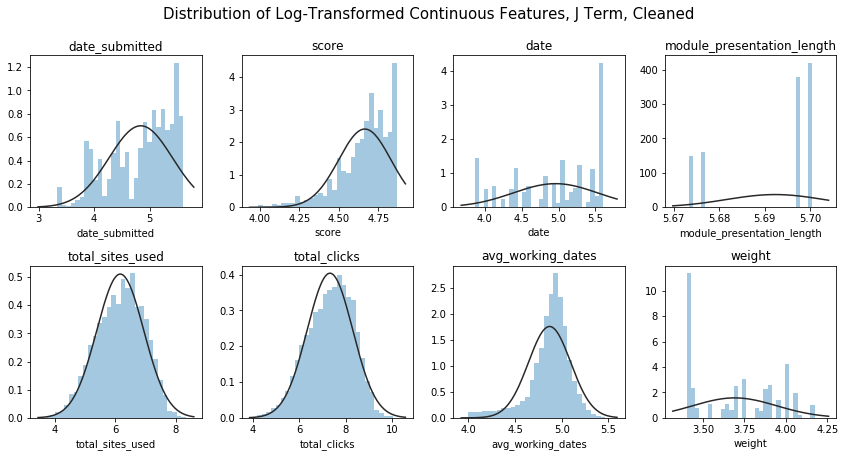

In [32]:
# J term
# visualize cleaned results, here log-transformed

cont_features_cleaned_j = tr_data_df_j[cont_features]

cont_features_log_cleaned_j = cont_features_cleaned_j.applymap(log30p)

# plot results
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for col, ax in zip(cont_features_log_cleaned_j, axes.flat):
    # plot Gaussian curve on top of transformed features to see difference to normal distribution
    ax = sns.distplot(cont_features_log_cleaned_j[col], bins = 30, hist = True, kde = False,
                      fit = norm, ax = ax)
    ax.set_title(col)

fig.suptitle("Distribution of Log-Transformed Continuous Features, J Term, Cleaned",
             y = 1.05, size = 15)
fig.tight_layout() # avoids overlapping labels
plt.show()

Similar to the combined set, we have again very nicely centered `total_sites_used`, `total_clicks` as well as `avg_working_dates`. `score` and `date_submitted` also look very alike to the combined set but also to the B term set. 

In general, the transformations have been successful in centering and condensing all values. This will be hugely beneficial to the following ML algorithms.

I will now also try an sqrt-transformation to see whether it might have a better centering.

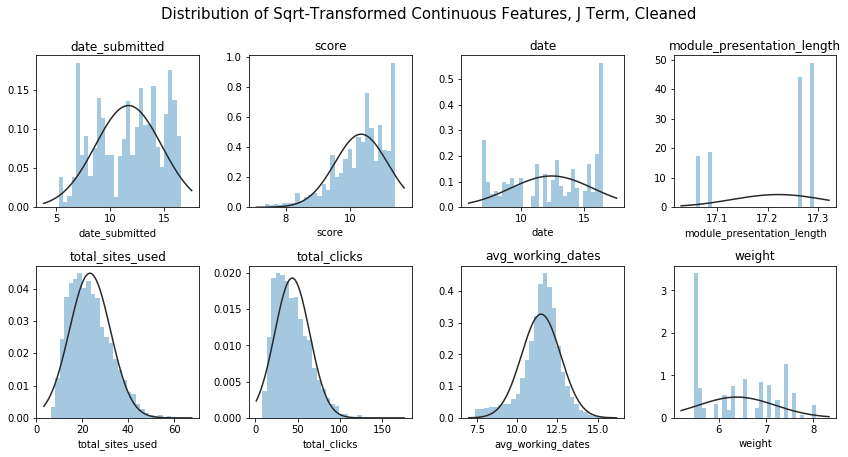

In [33]:
# try sqrt-transformation

cont_features_cleaned_test_j = tr_data_df_j[cont_features]

cont_features_sqrt_cleaned_j = cont_features_cleaned_test_j.applymap(sqrt30p)

# plot results
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for col, ax in zip(cont_features_sqrt_cleaned_j, axes.flat):
    # plot Gaussian curve on top of transformed features to see difference to normal distribution
    ax = sns.distplot(cont_features_sqrt_cleaned_j[col], bins = 30, hist = True, kde = False,
                      fit = norm, ax = ax)
    ax.set_title(col)

fig.suptitle("Distribution of Sqrt-Transformed Continuous Features, J Term, Cleaned",
             y = 1.05, size = 15)
fig.tight_layout() # avoids overlapping labels
plt.show()

In [34]:
# show final descriptive analysis of cleaned values
tr_data_df_j[cont_features].describe()

,date_submitted,score,date,module_presentation_length,total_sites_used,total_clicks,avg_working_dates,weight
count,62447.000000,62447.000000,62447.000000,62447.000000,62447.000000,62447.000000,62447.000000,62447.000000
mean,116.271734,77.522651,134.553653,266.580748,597.693788,2309.578250,103.314508,11.411085
std,70.220014,16.358561,78.789693,3.177677,480.596166,2261.048056,27.066476,10.596300
min,-6.000000,24.000000,18.000000,261.000000,10.000000,35.000000,24.413408,0.000000
25%,52.000000,67.000000,54.000000,262.000000,241.000000,734.000000,89.617225,0.000000
50%,117.000000,80.000000,131.000000,268.000000,467.000000,1608.000000,105.207729,10.000000
75%,172.000000,90.000000,215.000000,269.000000,812.000000,3159.000000,119.115424,20.000000
max,243.000000,100.000000,241.000000,269.000000,4158.000000,28615.000000,218.882353,35.000000


As expected due to the results of all other sets, the log-transformation delivers the superior results. The three engineered features `total_sites_used`, `total_clicks`, and `date_submitted` are still skewed to the left in the sqrt-transformation, and therefore I prefer the log-transformation. All other columns follow the pattern of the combined or B term model.

The descriptive statistics also show a beneficial theme as the standard deviation has again been lowered across all features, which means that the cleaning process was successfull. The trained model coefficients will now be more robust against outliers, which will produce more stable results.
___
### EDA of Merged Feature Space
In the following section, I will now explore the important relationships between the target variable `final_result` and all features in the final feature space. I will base the analysis on the cleaned and combined train set `tr_data_df`. As we just saw above, the combined set is a weighted average of the B- and J-term and thus the visualizations and distributions are very similar. Hence, I will only visualize the combined set.

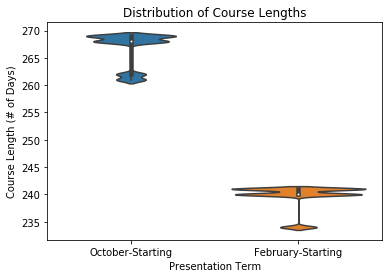

In [35]:
# create violin plot of course length difference according to February and October terms
plt.figure(figsize = (6, 4))
ax = sns.violinplot(x = tr_data_df["presentation_term"], y = tr_data_df["module_presentation_length"])
ax.set_xticklabels(["October-Starting", "February-Starting"])
ax.set_title("Distribution of Course Lengths")
ax.set_xlabel("Presentation Term")
ax.set_ylabel("Course Length (# of Days)")
plt.show()

We can see here much more intuitively that courses starting in February are, indeed, always shorter than courses starting in October. In fact, even the longest February-starting course is shorter than the shortest October-starting course. Thus, it really makes sense to adhere to the proposed good-practices hint of Open University to separetely analyse `B` and `J` terms. Let's check whether there is a relation to the final results.

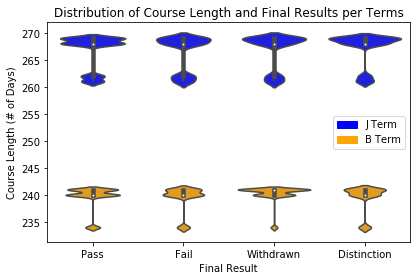

In [36]:
# presentation terms and final results
from matplotlib.patches import Patch as lbl_patch

# slice for presentation terms
b_term = tr_data_df.loc[tr_data_df["presentation_term"] == "B", "module_presentation_length"]
j_term = tr_data_df.loc[tr_data_df["presentation_term"] == "J", "module_presentation_length"]

plt.figure(figsize = (6, 4))
sns.violinplot(x = tr_data_df["final_result"], y = b_term, color = "orange")
sns.violinplot(x = tr_data_df["final_result"], y = j_term, color = "blue")

# custom labels
blue_patch = lbl_patch(color = "blue", label = "J Term")
orange_patch = lbl_patch(color = "orange", label = "B Term")

plt.title("Distribution of Course Length and Final Results per Terms")
plt.xlabel("Final Result")
plt.ylabel("Course Length (# of Days)")
plt.legend(handles = [blue_patch, orange_patch], loc = "center right")
plt.tight_layout()
plt.show()

There are, indeed, strong differences in terms of `Fail`, `Withdrawn`, and `Distinction`. `Pass` is distributed equally. 

In the J term, which is the longer term, we can observe that there are more courses and thus more students who fail when the term goes longer than 265 days. However, there are also more students who finish with distinction when courses are above 265 days. For the B term, we can observe that students withdraw most often from courses that are more than 240 days and very rarely from courses below 240 days. For students who withdraw in the J term, we can observe that this pattern is divided: for once, a lot of students withdraw in course with ~260 days, and then there is another big pattern along courses between 265 and 270 days.

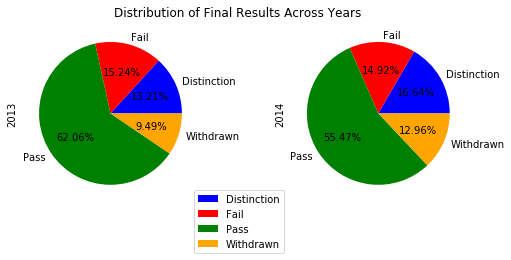

In [37]:
# check whether there is a difference in final results among years

# group first for presentation year, then for final results
years_grp = tr_data_df.groupby(["final_result", "presentation_year"]).count()

# plot results
plots = years_grp.unstack()["id_student"].plot.pie(subplots = True, figsize = (8, 6), autopct = "%.2f%%",
                                                  colors = ["blue", "red", "green", "orange"])
plots[0].get_legend().remove() # hide one legend
plots[1].legend(bbox_to_anchor = (0.0, 0.1))

plt.suptitle("Distribution of Final Results Across Years", y = 0.75)
plt.subplots_adjust(wspace = 0.5) # pull subplots apart horizontally
plt.show()

In [38]:
# how many courses per year
tr_data_df.groupby("presentation_year").nunique()["code_module"]

presentation_year
2013    6
2014    7
Name: code_module, dtype: int64

From the two distributions above we can see that the term has, indeed, a strong effect on final outcomes. The violinplots show very differing result patterns between B- and J-terms. The years, however, look basically the same. If we consider that the 2014 presentation year has one more course than 2013, we can neglect the at most ~6.5 percentage point difference in the `pass` category. The `fail` category suggests virtually no difference, `distinction` differs around 3.5 percentage points, as does `withdrawn`. To me, this is not enough of a differentiating factor to keep the year column.

Going forward, I will only use `presentation_term` as the indicator variable for the two terms.

For the following plots, we have to first slice the `tr_data_df` to only include unique combinations of `id_student` and `code_module`. As the `final_result` column indicates the end result after all assessments, not getting the unique values of a student per individual course would take into account multiplied data of students who had multiple assessments per course. This would skew the visualization.

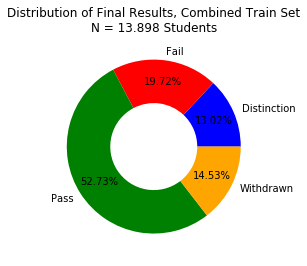

In [39]:
# final results in general

# slice for combination of unique id_student and code_module
tr_data_df_unq = tr_data_df.drop_duplicates(subset = ["id_student", "code_module"]).copy()

# group for final results
fnl_result = tr_data_df_unq.groupby(by = "final_result").count()["id_student"]

plt.pie(x = fnl_result, autopct = "%.2f%%", labels = fnl_result.index, pctdistance = 0.75,
        wedgeprops = dict(width = 0.5), colors = ["blue", "red", "green", "orange"])

plt.title("Distribution of Final Results, Combined Train Set\nN = 13.898 Students")
plt.show()

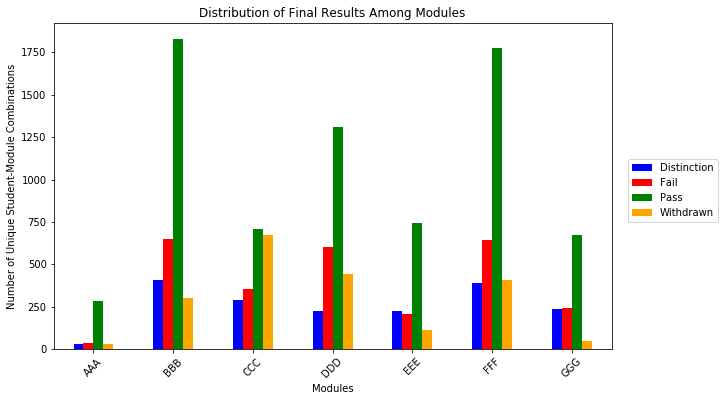

In [40]:
# code module and final results
tr_data_df_unq = tr_data_df_unq.sort_values(by = "code_module", ascending = True) # AAA at beginning

# group the df on first level by code_module, then by final_result, slice for any col as numbers are same
# grouping is also necessary for easier calculation of below statistics
results_per_module = tr_data_df_unq.groupby(by = ["code_module", "final_result"]).count()["id_student"]

# unstack the sliced dataframe and plot grouped results
results_per_module.unstack().plot.bar(color = ["blue", "red", "green", "orange"], figsize = (10, 6))
plt.title("Distribution of Final Results Among Modules")
plt.xlabel("Modules")
plt.ylabel("Number of Unique Student-Module Combinations")
plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor = (1.2, 0.6))
plt.show()

In [41]:
print("rate of withdrawing students in module CCC: {:.2f}".format(
    results_per_module.CCC.Withdrawn / results_per_module.CCC.sum()))
print("rate of withdrawing students in module GGG: {:.2f}".format(
    results_per_module.GGG.Withdrawn / results_per_module.GGG.sum()))
print("rate of distinction-finishing students in module EEE: {:.2f}".format(
    results_per_module.EEE.Distinction / results_per_module.EEE.sum()))
print("rate of distinction-finishing students in module FFF: {:.2f}".format(
    results_per_module.AAA.Distinction / results_per_module.AAA.sum()))
print("rate of failing students in module BBB: {:.2f}".format(
    results_per_module.BBB.Fail / results_per_module.BBB.sum()))
print("rate of failing students in module DDD: {:.2f}".format(
    results_per_module.DDD.Fail / results_per_module.DDD.sum()))
print("rate of failing students in module AAA: {:.2f}".format(
    results_per_module.AAA.Fail / results_per_module.AAA.sum()))

rate of withdrawing students in module CCC: 0.33
rate of withdrawing students in module GGG: 0.04
rate of distinction-finishing students in module EEE: 0.17
rate of distinction-finishing students in module FFF: 0.08
rate of failing students in module BBB: 0.20
rate of failing students in module DDD: 0.23
rate of failing students in module AAA: 0.09


Remember: `AAA`, `BBB`, `GGG` are social science modules.

First, we can see here that the most assessments are written in the `BBB` and `FFF` module, and that the overwhelming majority of students pass the module. The least assessments are written in `AAA`. 

In general, students are very successfull in every module, meaning that the majority of students always passes more often than fails or withdraw. Module `CCC`, however, has almost as many students withdrawing than passing. Combinding `fail` and `withdraw` results in a greater portion of students not passing than passing.

In general, the rates of each category are very different, which is key for our classification. For instance, a student enrolling in `CCC` has a chance of withdrawing of 33% compared to only 4% in module `GGG`. In another example, students participating in module `EEE` are finishing the module with distinction in 17% of all cases. In module `AAA`, these are only 8% students finishing with distinction. When comparing rates of failing students, both modules `BBB` and `DDD` have failing rates of 20% and 23%, respectively. In comparison, module `AAA` only has a failure rate of 9%. 

These differences are important to incorporate into classification modules, so it is key to include the `code_module` variable.

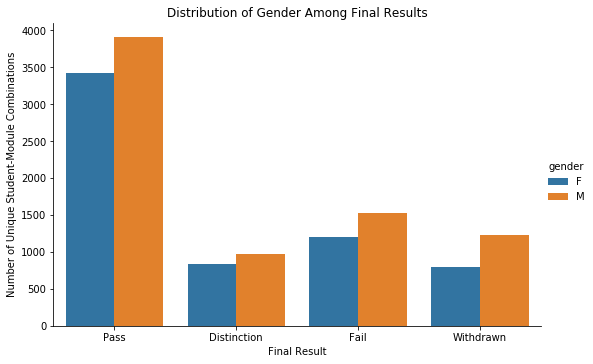

In [42]:
# gender and final results
sns.catplot(x = "final_result", hue = "gender", data = tr_data_df_unq, kind = "count", height = 5,
            aspect = 1.5)
plt.xlabel("Final Result")
plt.ylabel("Number of Unique Student-Module Combinations")
plt.title("Distribution of Gender Among Final Results")
plt.show()

In [43]:
# statistics for gender distribution
f_m_dist = tr_data_df_unq["gender"].value_counts() / tr_data_df_unq["gender"].value_counts().sum()
print("Distribution of general course attendance among genders: male = {:.2f}, female = {:.2f}".format(
    f_m_dist[0], f_m_dist[1]))

# final results per gender
results_per_gender = tr_data_df_unq.groupby(by = ["gender", "final_result"]).count()["id_student"]

print("rate of passing: male = {:.2f}, female = {:.2f}".format(
    results_per_gender.M.Pass / results_per_gender.sum(),
    results_per_gender.F.Pass / results_per_gender.sum()))
print("rate of passing with distinction: male = {:.2f}, female = {:.2f}".format(
    results_per_gender.M.Distinction / results_per_gender.sum(),
    results_per_gender.F.Distinction / results_per_gender.sum()))
print("rate of failing: male = {:.2f}, female = {:.2f}".format(
    results_per_gender.M.Fail / results_per_gender.sum(),
    results_per_gender.F.Fail / results_per_gender.sum()))
print("rate of withdrawing: male = {:.2f}, female = {:.2f}".format(
    results_per_gender.M.Withdrawn / results_per_gender.sum(),
    results_per_gender.F.Withdrawn / results_per_gender.sum()))

Distribution of general course attendance among genders: male = 0.55, female = 0.45
rate of passing: male = 0.28, female = 0.25
rate of passing with distinction: male = 0.07, female = 0.06
rate of failing: male = 0.11, female = 0.09
rate of withdrawing: male = 0.09, female = 0.06


In this set, there are more male than female students by a margin of 10 percentage points.

Whereas the ratio of finishing with distinction is very close, males tend to fail and withdraw slightly more than females. Nevertheless, they also pass on average more than females with a 3 percentage point lead.

Considering that there are more males in this set, I think it is especially useful to keep this variable when it comes to finishing with distinction as females tend to overperform in that category. I will therefore consider the difference among genders in the final feature space.

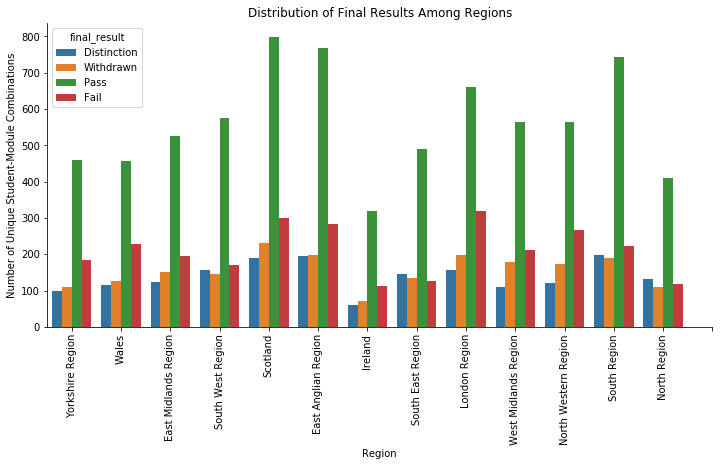

In [44]:
# region and final result, again based on unique id_student+code_module combinations

sns.catplot(x = "region", hue = "final_result", data = tr_data_df_unq, kind = "count", height = 5,
            aspect = 2, legend_out = False, hue_order = ["Distinction", "Withdrawn", "Pass", "Fail"])
plt.xticks(ticks = np.arange(0, 14),
          labels = tr_data_df_unq["region"].unique(),
          rotation = 90)
plt.xlabel("Region")
plt.ylabel("Number of Unique Student-Module Combinations")
plt.title("Distribution of Final Results Among Regions")
plt.show()

In [45]:
# get rates for every column

# group by region first, final_result second, slice for any column as numberse are same for .count()
results_per_region = tr_data_df_unq.groupby(by = ["region", "final_result"]).count()["id_student"]

pd.DataFrame(results_per_region) / pd.DataFrame(results_per_region).sum(axis = 0, level = 0)

id_student
region               final_result            
East Anglian Region  Distinction     0.135640
                     Fail            0.196540
                     Pass            0.530796
                     Withdrawn       0.137024
East Midlands Region Distinction     0.125376
                     Fail            0.194584
                     Pass            0.528586
                     Withdrawn       0.151454
Ireland              Distinction     0.107965
                     Fail            0.200000
                     Pass            0.564602
                     Withdrawn       0.127434
London Region        Distinction     0.116942
                     Fail            0.239130
                     Pass            0.494753
                     Withdrawn       0.149175
North Region         Distinction     0.171206
                     Fail            0.154345
                     Pass            0.531777
                     Withdrawn       0.142672
North Western Region Distinction     0.107556
                     Fail            0.238222
                     Pass            0.500444
                     Withdrawn       0.153778
Scotland             Distinction     0.125658
                     Fail            0.198026
                     Pass            0.524342
                     Withdrawn       0.151974
South East Region    Distinction     0.162946
                     Fail            0.140625
                     Pass            0.545759
                     Withdrawn       0.150670
South Region         Distinction     0.146972
                     Fail            0.163959
                     Pass            0.548006
                     Withdrawn       0.141064
South West Region    Distinction     0.150620
                     Fail            0.163012
                     Pass            0.548141
                     Withdrawn       0.138227
Wales                Distinction     0.125000
                     Fail            0.244612
                     Pass            0.493534
                     Withdrawn       0.136853
West Midlands Region Distinction     0.103578
                     Fail            0.198682
                     Pass            0.530132
                     Withdrawn       0.167608
Yorkshire Region     Distinction     0.115023
                     Fail            0.217136
                     Pass            0.538732
                     Withdrawn       0.129108

Even though the visualization looks like there are great differences among the regions, the percentages show that that the variations are a lot narrower.

For instance, West Midlands Region only has 10% distinctions, whereas North Region is has above 17%. Most other regions are around 12%. The passing rate is generally around 53% with few exceptions below (e.g. Wales and London at 49%), and Ireland at 56%. The failure rate is mostly around 21% with some positive exceptions like South Eastern Region at only 14% as well as some negative exceptions like Wales and North Western Region at 24%. Withdrawal rates are roughly equally distributed in ranges of 12-15%.

Despite the trends being not as concrete as in other features, this feature still shows regular variations of around 5 percentage points among final results and regions. Therefore, the observed differences in this feature will still benefit our model - by itself as well as in combination with other features.

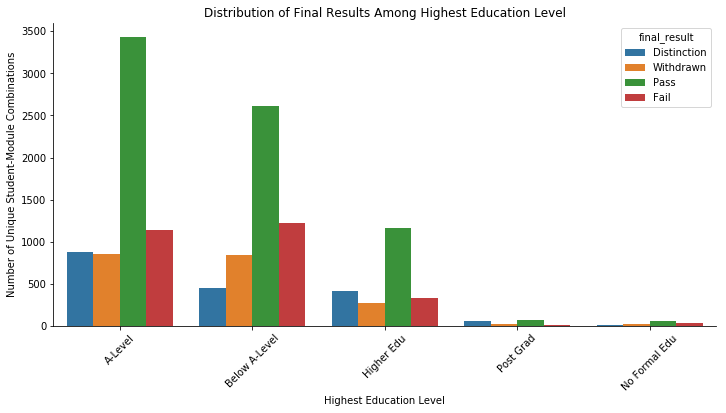

In [46]:
# highest_education and final result, also using unique student+module combinations

sns.catplot(x = "highest_education", hue = "final_result", data = tr_data_df_unq, kind = "count",
            legend_out = False, height = 5, aspect = 2,
            hue_order = ["Distinction", "Withdrawn", "Pass", "Fail"])
plt.title("Distribution of Final Results Among Highest Education Level")
plt.xlabel("Highest Education Level")
plt.ylabel("Number of Unique Student-Module Combinations")
plt.xticks(ticks = np.arange(0, 6),
           labels = ["A-Level", "Below A-Level", "Higher Edu", "Post Grad", "No Formal Edu"],
          rotation = 45)
plt.xlim(right = 4.5)
plt.show()

In [47]:
# get rates for every column

# group first level by highest_education, then by final_result, slice for any col as numbers are same
results_per_edu = tr_data_df_unq.groupby(by = ["highest_education", "final_result"]).count()["id_student"]

pd.DataFrame(results_per_edu) / pd.DataFrame(results_per_edu).sum(axis = 0, level = 0)

id_student
highest_education           final_result            
A Level or Equivalent       Distinction     0.139933
                            Fail            0.180073
                            Pass            0.543709
                            Withdrawn       0.136284
HE Qualification            Distinction     0.190367
                            Fail            0.150917
                            Pass            0.533486
                            Withdrawn       0.125229
Lower Than A Level          Distinction     0.087185
                            Fail            0.239126
                            Pass            0.510240
                            Withdrawn       0.163448
No Formal quals             Distinction     0.089431
                            Fail            0.268293
                            Pass            0.430894
                            Withdrawn       0.211382
Post Graduate Qualification Distinction     0.327273
                            Fail            0.103030
                            Pass            0.424242
                            Withdrawn       0.145455

Some noteworthy instances of differences of final result rates among the education levels are:
* Students with a Post Graduate education earn _distinction_ at a rate of ~33% (highest) while the group of _Lower than A-Levels_ only finishes with distinction at ~9% (lowest)
* _No Formal Qualifications_ has a _Pass_ rate of 43%, every other group except _Post Grad_ is at 51%-54%. _Post Grad_ is only at 42% passing because 33% are finishing with distinction.
* The withdrawing rate is highest (21%) for the _No formal qualifications_ group. All other groups are below 16%. 
* Students in the _Post Graduate_ group only fail at a rate of 10%, students in the _Below A-Level_ group as well as _No Formal Qualification_ fail around 24%-27%. Both other groups, _A-Level_ and _Higher Education_, are in the middle at around 18% and 15%.

Because of these pattern and trends, I consider this demographic feature to be very important in our classification problem.

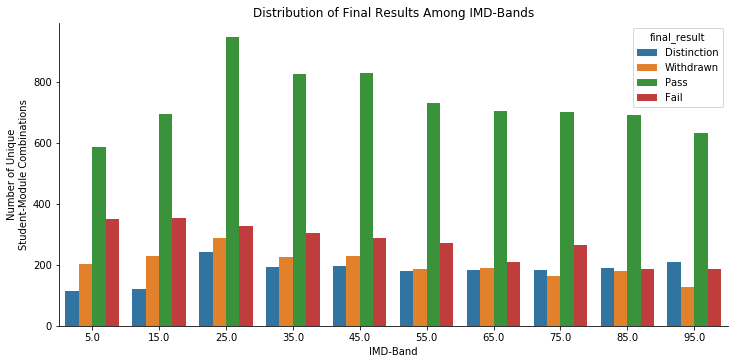

In [48]:
# imd_band (economic+social strength of region) and final results

sns.catplot(x = "imd_band", hue = "final_result", data = tr_data_df_unq, kind = "count", height = 5,
            aspect = 2, hue_order = ["Distinction", "Withdrawn", "Pass", "Fail"], legend_out = False,
           row_order = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95])
plt.title("Distribution of Final Results Among IMD-Bands")
plt.xlabel("IMD-Band")
plt.ylabel("Number of Unique\nStudent-Module Combinations")
plt.show()

In [49]:
# get rates for every column

# group by imd_band first, final_result second, slice for any column as numberse are same for .count()
results_per_imd = tr_data_df_unq.groupby(by = ["imd_band", "final_result"]).count()["id_student"]

pd.DataFrame(results_per_imd) / pd.DataFrame(results_per_imd).sum(axis = 0, level = 0)

id_student
imd_band final_result            
5.0      Distinction     0.091633
         Fail            0.279681
         Pass            0.467729
         Withdrawn       0.160956
15.0     Distinction     0.086738
         Fail            0.252330
         Pass            0.496057
         Withdrawn       0.164875
25.0     Distinction     0.133889
         Fail            0.181111
         Pass            0.525000
         Withdrawn       0.160000
35.0     Distinction     0.123785
         Fail            0.197667
         Pass            0.533377
         Withdrawn       0.145172
45.0     Distinction     0.127922
         Fail            0.186364
         Pass            0.537013
         Withdrawn       0.148701
55.0     Distinction     0.130403
         Fail            0.199267
         Pass            0.534799
         Withdrawn       0.135531
65.0     Distinction     0.142191
         Fail            0.163170
         Pass            0.547009
         Withdrawn       0.147630
75.0     Distinction     0.140137
         Fail            0.201828
         Pass            0.533130
         Withdrawn       0.124905
85.0     Distinction     0.152366
         Fail            0.148356
         Pass            0.554130
         Withdrawn       0.145148
95.0     Distinction     0.181266
         Fail            0.162186
         Pass            0.546401
         Withdrawn       0.110147

We can observe some interesting trends here:
* The rate of distinction-finishing students rises continuously (3 exceptions below 1 percentage point in categories 15, 35, 45) from 9% in the most deprived area up to 18% in the least deprived area.
* The rate of failure drops from ~28% in the most deprived area down to ~16% in the least deprived area. There are multiple exceptions in this process, and the lowest failing rate is in the 85 category with ~15%. Nevertheless, there is still a trend recognizable, which is beneficial to our classification.
* The rate of passing grows almost steadily (2 exceptions in the 75 and 95 category with ~1 percentage point against the trend) from ~46% in the most deprived area to ~55% in the least deprived area.
* The withdrawal drops consistantly (1 exception in the 85 category) from the most desprived area around 16% to  11% in the least deprived arena.

This feature provides clear trends that will benefit the classification models later on, therefore, the feature stays in the model.

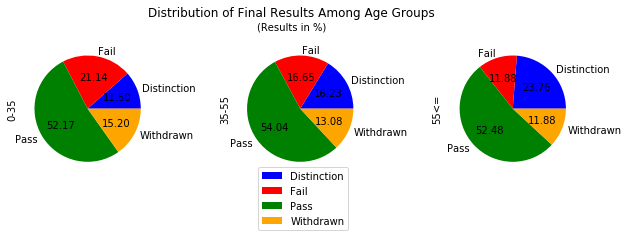

In [50]:
# age and final results

# slice for age groups
results_per_age = tr_data_df_unq.groupby(by = ["final_result", "age_band"]).count()

# plot results
plots = results_per_age.unstack()["id_student"].plot.pie(
    subplots = True, figsize = (10, 8), autopct = "%.2f", colors = ["blue", "red", "green", "orange"],
    pctdistance = 0.6)
plots[0].get_legend().remove() # hide all legends besides one
plots[1].get_legend().remove() # hide all legends besides one
plots[2].legend(bbox_to_anchor = (-0.7, 0.1))

plt.suptitle("Distribution of Final Results Among Age Groups", y = 0.68)
plt.figtext(x = 0.5, y = 0.64, s = "(Results in %)", ha = "center")
plt.subplots_adjust(wspace = 0.6) # pull subplots apart horizontally
plt.show()

While the `pass` class is almost equally distributed across all age groups, there are clear trends among all 3 other classes:
* Students below age 35 fail at a rate of 21%, students between age 35 and 55 only fail at ~17%, and students above 55 fail only at 12%
* Students below age 35 finish with distinction at 11.5%, between age 35 and 55 they finish with 16%, and above age 55 students reach distinction status at ~24%
* In the below-35 group, students withdraw at a rate of 15%, while students between age 35 and 55 only withdraw at 13%, whereas students in the above-55 group drop out at an even lower rate of 11.88%.

As there are clear trends recognizable, this feature will definitely be in the final feature matrix.

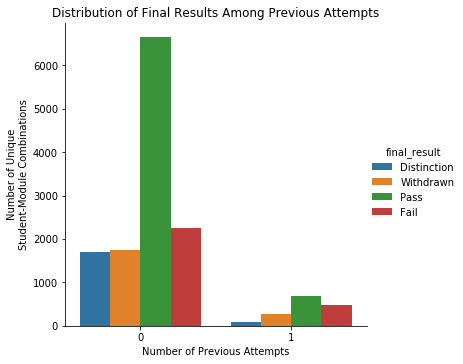

In [51]:
# previous attempts and final results

sns.catplot(x = "num_of_prev_attempts", hue = "final_result", data = tr_data_df_unq, kind = "count",
            height = 5, aspect = 1, hue_order = ["Distinction", "Withdrawn", "Pass", "Fail"])
plt.title("Distribution of Final Results Among Previous Attempts")
plt.xlabel("Number of Previous Attempts")
plt.ylabel("Number of Unique\nStudent-Module Combinations")
plt.show()

In [52]:
# get distribution in absolute numbers
tr_data_df_unq["num_of_prev_attempts"].value_counts()

0    12363
1     1535
Name: num_of_prev_attempts, dtype: int64

In [53]:
# get rates for every column

# group by imd_band first, final_result second, slice for any column as numberse are same for .count()
results_per_attempt = tr_data_df_unq.groupby(
    by = ["num_of_prev_attempts", "final_result"]).count()["id_student"]

pd.DataFrame(results_per_attempt) / pd.DataFrame(results_per_attempt).sum(axis = 0, level = 0)

id_student
num_of_prev_attempts final_result            
0                    Distinction     0.138397
                     Fail            0.181995
                     Pass            0.537976
                     Withdrawn       0.141632
1                    Distinction     0.063844
                     Fail            0.319218
                     Pass            0.441694
                     Withdrawn       0.175244

While there are very few students even going in second attempts, having data on about 1500 students still provides representative results to use here. The grouping of all attempts of 1 and above was therefore very useful.

We can see here that students going into the second attempt have only about half of the first attempt students' distinction rate: now around 6%. The failing rate in comparison to first-try students has almost doubled from 18% to now 32%. Students also pass at around a 10 percentage points lower rate: from initially 54% to now 44%. The withdrawal rates also rises to around 17.5% from 14%, which isn't a huge jump but still enough to notice.

In general, this feature, as it is grouped now, will be beneficial to classification outcomes and will thus be in the feature space.

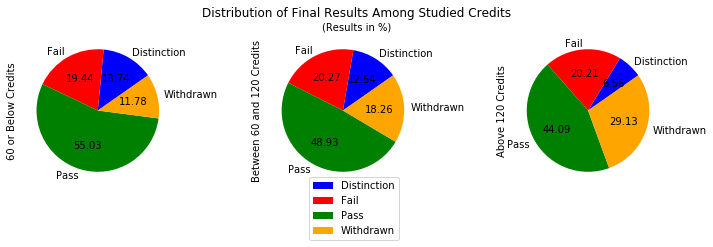

In [54]:
# studied credits and final results

# slice for credits, reminder: 0 --> 60 or below credits, 1 --> between 61 and 120, 2 --> 121+ credits
results_per_credits = tr_data_df_unq.groupby(by = ["final_result", "studied_credits"]).count()

# plot results
plots = results_per_credits.unstack()["id_student"].plot.pie(
    subplots = True, figsize = (10, 8), autopct = "%.2f", colors = ["blue", "red", "green", "orange"],
    pctdistance = 0.6, startangle = 35)
plots[0].get_legend().remove() # hide all legends besides one
plots[1].get_legend().remove() # hide all legends besides one
plots[2].legend(bbox_to_anchor = (-0.7, 0.1))

plots[0].set_ylabel("60 or Below Credits")
plots[1].set_ylabel("Between 60 and 120 Credits")
plots[2].set_ylabel("Above 120 Credits")

plt.tight_layout()
plt.suptitle("Distribution of Final Results Among Studied Credits", y = 0.68)
plt.figtext(x = 0.5, y = 0.64, s = "(Results in %)", ha = "center")
plt.subplots_adjust(wspace = 0.6) # pull subplots apart horizontally
plt.show()

There aren't any notable trends for `fail`, however we can see definitive trends for all other 3 features.
* Students studying for one year or less worth of credits pass at a 55% rate, when studying for 60-120 credits, they only pass on average 49%, and when studying for more than two years worth of credits, they pass only 44% of the time.
* The rate of finishing with distinction also drops continuously: For 60 or below credits, ~14% finish with distinction, when studying between 60 and 120 credits, the rate drops to 12.5%, and when studying for more than 120 credits, the rate drops sharply to 6.5%.
* The rate of withdrawing students rises across the 3 categories: For 60 or below credits, students withdraw around 12% of times, when considering the 60 to 120 category, the rate rises to 18%, and when studying for more than 120 credits, students almost a third (29%) of students with withdraw from modules.

As these categories differentiate nicely among final results, I will keep this variable in the final feature space.

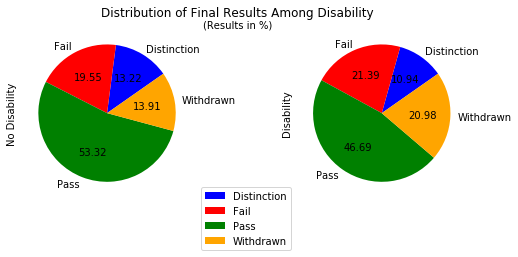

In [55]:
# disability and final results

# slice for disability
results_per_disability = tr_data_df_unq.groupby(by = ["final_result", "disability"]).count()

# plot results
plots = results_per_disability.unstack()["id_student"].plot.pie(
    subplots = True, figsize = (8, 6), autopct = "%.2f", colors = ["blue", "red", "green", "orange"],
    pctdistance = 0.6, startangle = 35)
plots[0].get_legend().remove() # hide all legends besides one
plots[1].legend(bbox_to_anchor = (0, 0.1))

plots[0].set_ylabel("No Disability")
plots[1].set_ylabel("Disability")

plt.suptitle("Distribution of Final Results Among Disability", y = 0.75)
plt.figtext(x = 0.5, y = 0.7, s = "(Results in %)", ha = "center")
plt.subplots_adjust(wspace = 0.6) # pull subplots apart horizontally
plt.show()

The `fail` rate is very stable with 20% to 21% regarding no disability and present disability status. The `pass` and `distinction` rates also only slightly show variation with 53% to 47% as well as 13% to 11%, respectively. However, the withdrawing rate rises from 14% to 21% for the students with disability.

These are rather minor classification indications, but I will still keep this feature in the final feature matrix as it still sheds light on differences among final results.

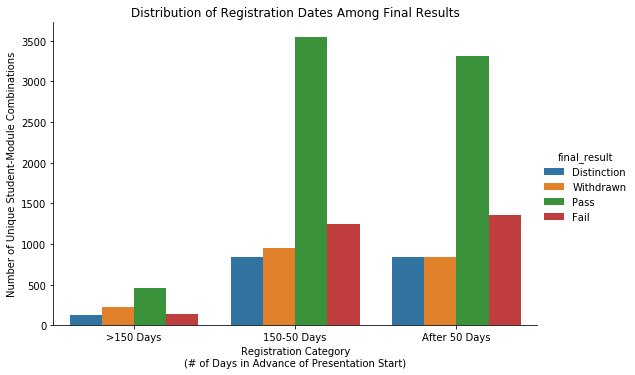

In [56]:
# date_registration per final result

sns.catplot(x = "date_registration", hue = "final_result", data = tr_data_df_unq, kind = "count",
           height = 5, aspect = 1.5, hue_order = ["Distinction", "Withdrawn", "Pass", "Fail"])
plt.title("Distribution of Registration Dates Among Final Results")
plt.xlabel("Registration Category\n(# of Days in Advance of Presentation Start)")
plt.ylabel("Number of Unique Student-Module Combinations")
plt.xticks(ticks = np.arange(3), labels = [">150 Days", "150-50 Days", "After 50 Days"])
plt.show()

In [57]:
# get absolute values for comparison
print("absolute values:\n", tr_data_df_unq["date_registration"].value_counts())

# get rates for every column

# group by registration_date first, final_result second
results_per_registration = tr_data_df_unq.groupby(
    by = ["date_registration", "final_result"]).count()["id_student"]

pd.DataFrame(results_per_registration) / pd.DataFrame(results_per_registration).sum(axis = 0, level = 0)

absolute values:
 -50.0     6586
 50.0     6353
-150.0     959
Name: date_registration, dtype: int64


id_student
date_registration final_result            
-150.0            Distinction     0.133472
                  Fail            0.143900
                  Pass            0.482795
                  Withdrawn       0.239833
-50.0             Distinction     0.127847
                  Fail            0.188430
                  Pass            0.539326
                  Withdrawn       0.144397
 50.0             Distinction     0.132064
                  Fail            0.214229
                  Pass            0.521643
                  Withdrawn       0.132064

While there is a smaller sample size for the category of 150 days in advance, there are still 959 values in this set, which is enough to be representative and not only distort the results. 

* The distinction category doesn't show any trend at all: all catetegories are at 13%
* The fail rate does indeed show a trend: Students who registered very early fail only at 14% on average, students in the middle category fail at 19%, and students in the last category fail at 21%
* The pass category shows a trend that I didn't expect: The earliest category has a lower passing rate than both the middle and late category, with the values being 48% to 54% and 52% respectively. 
* The withdrawal allows us to observe another worthwile trend for classification: The students in the earliest registration category withdraw at a much higher rate (24%) than students in the other categories (14% and 13%). This could be due to having more time to pick other courses, or maybe also that the students haven't put much research in course choice. The fact that these students don't have a higher distinction rate (which I would interpret as being determined early on and thus powering through the module) may show that they aren't any more interested in the course as other, later registering students.

In general, this feature provides two useful trends for classification and whill thus be part of the final feature space.

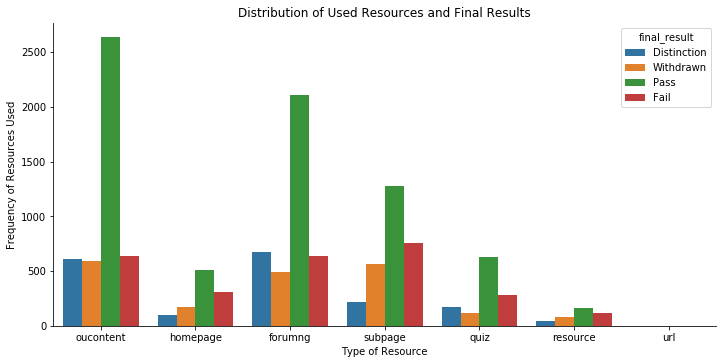

In [58]:
# activity_type (specific resources) per final results

sns.catplot(x = "activity_type", hue = "final_result", data = tr_data_df_unq, kind = "count", height = 5,
           aspect = 2, hue_order = ["Distinction", "Withdrawn", "Pass", "Fail"], legend_out = False)
plt.title("Distribution of Used Resources and Final Results")
plt.xlabel("Type of Resource")
plt.ylabel("Frequency of Resources Used") # number of unique students-module combinations
plt.show()

In [59]:
# get rates of used resources
results_per_resource = tr_data_df_unq.groupby(by = ["activity_type", "final_result"]).count()["id_student"]

pd.DataFrame(results_per_resource) / pd.DataFrame(results_per_resource).sum(axis = 0, level = 0)

id_student
activity_type final_result            
forumng       Distinction     0.171911
              Fail            0.163725
              Pass            0.537989
              Withdrawn       0.126375
homepage      Distinction     0.092406
              Fail            0.281793
              Pass            0.469350
              Withdrawn       0.156450
oucontent     Distinction     0.135540
              Fail            0.143368
              Pass            0.589354
              Withdrawn       0.131738
quiz          Distinction     0.143095
              Fail            0.232945
              Pass            0.524958
              Withdrawn       0.099002
resource      Distinction     0.098522
              Fail            0.290640
              Pass            0.408867
              Withdrawn       0.201970
subpage       Distinction     0.077142
              Fail            0.267330
              Pass            0.455030
              Withdrawn       0.200498
url           Distinction     0.250000
              Fail            0.250000
              Pass            0.250000
              Withdrawn       0.250000

We can see that there are clear differences among the resources used and their effectiveness. For instance,
students using `subpage` as their most used resource only finish with `distinction` 8% of times. On the other hand, students who used `outcontent` and `quiz` almost double that rate with ~14%.

For the `Pass` category, `resource` has a below-average rate of only 41%, whereas `oucontent` has a rate of 59%. `forumng` follows with a 53% passing rate.

For the `Withdrawn` category, students who used `quiz` most often only withdrew at a rate of 9%. In comparison to that, `subpage`-using students dropped out at 20%, as did the students using `resource`.

Regarding failing, we also have some clear patterns. Students who used `resource`, `homepage`, or `subpage`, failed at rates of 29%, 28%, and 27%, respectively. On the other hand, when students used `forumng` or `outcontent`, they only failed the module at rates of 16% or 14%, respectively.

As there are very noticeable trends among the used resources, I will definitely incorporate this feature into our ML models' input space.

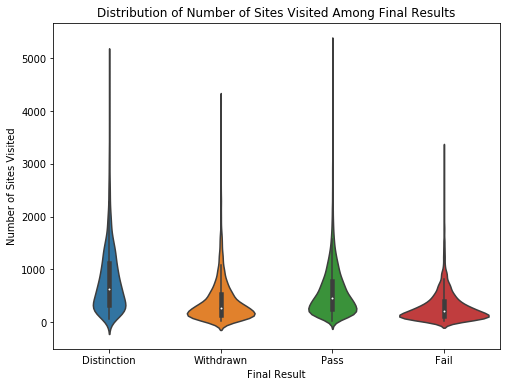

In [60]:
# number of sites used per student per outcome
plt.figure(figsize = (8, 6))
sns.violinplot(x = "final_result", y = "total_sites_used", data = tr_data_df_unq,
              order = ["Distinction", "Withdrawn", "Pass", "Fail"])
plt.title("Distribution of Number of Sites Visited Among Final Results")
plt.xlabel("Final Result")
plt.ylabel("Number of Sites Visited")
plt.show()

In [61]:
# get median of sites used in numerical form
tr_data_df_unq.groupby(by = "final_result").median()["total_sites_used"]

final_result
Distinction    636.0
Fail           215.0
Pass           452.0
Withdrawn      274.0
Name: total_sites_used, dtype: float64

This graph visualizes very intuitively that students who finish with `Distinction` use at the median level the most sites - by a considerable step of 636 to 452 (median of `Pass`).

Passing students have the second highest median at 452, considerably below distinction, however, their top outliers are even above the ones of distinction-finishing students. This category has the bulk of students visibly above the ones of withdrawing and failing students. 

Students who `Fail` also use generally fewer sites (median = 215) to study. The upper ranges, i.e. what would be classified as outliers, are only 2/3 of what passing students use, too.

Withdrawing students form a similar distribution as failing students do, but they still put in more work (as measured here in number of sites used). Their median is at 274 and their upper outliers are also higher than the ones of failing students.

These graph and statistics indicate beautifully that this engineered feature provides lots of value towards classifying students as their is an unambiguous noticeable ranking among the classes.

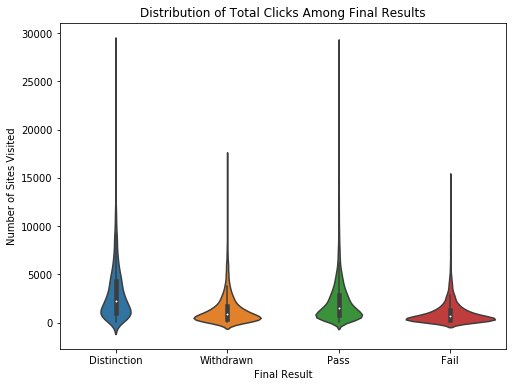

In [62]:
# number of clicks per outcome
plt.figure(figsize = (8, 6))
sns.violinplot(x = "final_result", y = "total_clicks", data = tr_data_df_unq, fliersize = 3,
            order = ["Distinction", "Withdrawn", "Pass", "Fail"])
plt.title("Distribution of Total Clicks Among Final Results")
plt.xlabel("Final Result")
plt.ylabel("Number of Sites Visited")
plt.show()

In [63]:
# get median click numbers
tr_data_df_unq.groupby(by = "final_result").median()["total_clicks"]

final_result
Distinction    2217.0
Fail            638.5
Pass           1493.0
Withdrawn       857.5
Name: total_clicks, dtype: float64

Similar to the `total_sites_used` feature, these plots draw a comparable and intuitive picture of the completed student activity or working load.

Students who fail courses click the least (median = 638.5) and have the lowest upper outliers.

The withdrawing students, who click slightly more often (median = 857.5) also have the second lowest upper outliers.

Passing students have a considerably higher click sum with a median of 1,493. They also have the second highest upper outliers, which is very intuitively visible above.

Students who pass with distinction have a median of 2,217, which is 724 clicks higher than students who pass. This is a step of more than the median working load of failing students, which really shows that distinction-finishing students put in a lot of additional work and time. Consequently, their upper outliers are also the highest.

This is also an engineered feature where the statistics and visualizations match the intuition of students who work more receive better results. The feature will definitely be incorporate into all following models.

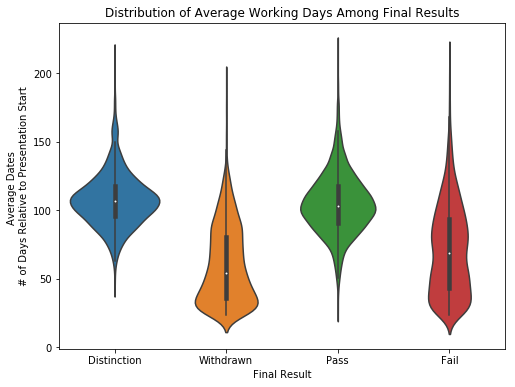

In [64]:
# average working days in relation to final results

plt.figure(figsize = (8, 6))
sns.violinplot(x = "final_result", y = "avg_working_dates", data = tr_data_df_unq, height = 4, aspect = 1.5,
              order = ["Distinction", "Withdrawn", "Pass", "Fail"])
plt.xlabel("Final Result")
plt.ylabel("Average Dates \n# of Days Relative to Presentation Start")
plt.title("Distribution of Average Working Days Among Final Results")
plt.show()

In [65]:
# get median working days
tr_data_df_unq.groupby(by = "final_result").median()["avg_working_dates"]

final_result
Distinction    106.728030
Fail            68.652612
Pass           103.442765
Withdrawn       54.220894
Name: avg_working_dates, dtype: float64

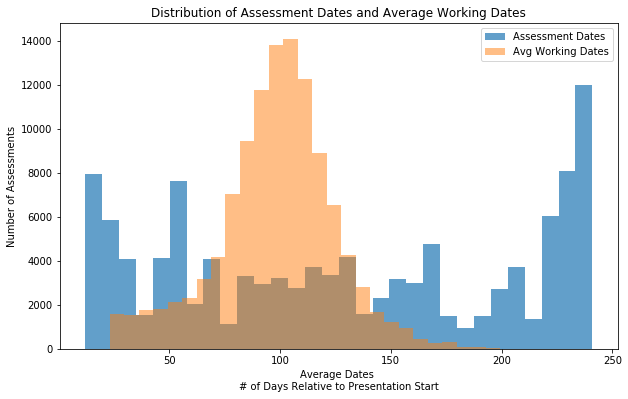

In [66]:
# visualize assessment dates for interpretation
# no unique student-module combinations here to get same scale

plt.figure(figsize = (10, 6))
plt.hist(tr_data_df["date"], bins = 30, alpha = 0.7, label = "Assessment Dates")
plt.hist(tr_data_df["avg_working_dates"], bins = 30, alpha = 0.5, label = "Avg Working Dates")
plt.xlabel("Average Dates \n# of Days Relative to Presentation Start")
plt.ylabel("Number of Assessments")
plt.title("Distribution of Assessment Dates and Average Working Dates")
plt.legend()
plt.show()

In the violinplots we can see distinctly that both groups of students who pass and pass with distinction have a very distinct distribution: they majority of data is centered strongly around the middle of the term. Both groups of students who withdraw from or fail the course more spread out over the term without clear activity patterns.

The median of all categories proves this from a numerical perspective: `Distinction` and `Pass` are at 106 and 103, `Withdrawn` and `Fail` are at 54 and 68 on a scale of 0 to ~240. 

The pattern of student passing and passing with distinction stems from the fact the `avg_working_dates` is also an engineered feature in which I took the average of all days when the student was active in the VLE. This number was supposed to be influenced by extremes because I wanted to observe when, for instance, students were more active before exam periods. The strong grouping around the middle is a consequence of the distribution of scheduled - and therefore sat - assessments. The histogram shows that assessments are mainly scheduled either very early in the term or around the end. The average of those assessment periods sets students who were active in those two periods directly in the middle of the term - as the `avg_working_dates` distribution reflects.

The patterns observerd here in these features will also contribute towards more successfully classifying our observations. Therefore, avg_working_dates will be used in all ML models.

For all following trends and pattern between features and the target variable, we will use again the whole combined train set `tr_data_df` - not the unique student-module combinations. This is because the following features depend on data for all assessments during the term, not only on the resulting final examination.

In [67]:
# id_assessment and final result

# group once only by id_assessment to change index
assessments_grp = tr_data_df.groupby(by = ["id_assessment"]).count()

# group second time by id_assessment and final_result
results_per_assessment = tr_data_df.groupby(by = ["id_assessment", "final_result"]).count()

# create a dict of grouped indices and a new index list starting at 0
assessments_rename = dict(zip(assessments_grp.index, np.arange(len(assessments_grp.index))))

# now use rename for the indices to have assessments of double-grouped df continuously starting at 0
results_per_assessment.rename(index = assessments_rename, level = 0, inplace = True)

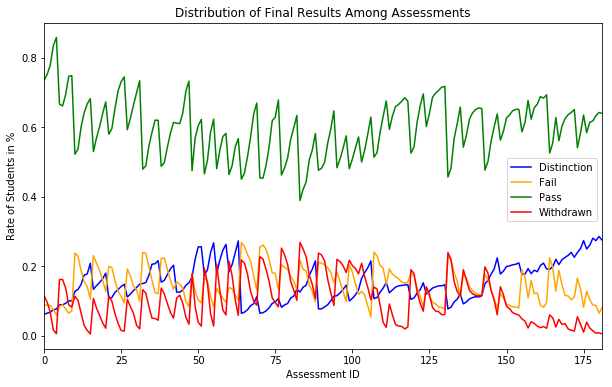

In [68]:
# visualize results as rates to normalize for number of students in each assessment
results_per_assessment_rate = pd.DataFrame(results_per_assessment["id_student"]) / pd.DataFrame(
    results_per_assessment["id_student"]).sum(axis = 0, level = 0)


results_per_assessment_rate.unstack()["id_student"].plot.line(color = ["blue", "orange", "green", "red"],
                                                             figsize = (10, 6))
plt.title("Distribution of Final Results Among Assessments")
plt.xlabel("Assessment ID")
plt.ylabel("Rate of Students in %")
plt.legend(bbox_to_anchor = (1, 0.6))
plt.show()

Each line in this visualization represents the rate of students who finished in each respective class, i.e. distinction, fail, pass, withdrawn. Each point on the x-axis represents one unique assessment. To get to 100%, one must add up all rates at a position $x$.

This graph is supposed to visualize the different rates in which students finish each assessment. We can see that `fail` and `withdrawn` move closely together, however, in the assessments ID range between ~15 and ~40, the withdrwal rate was higher than the failure rate. In the assessment ID range between ~50 and ~60, the failure rate was greater. For some assessments between ID 50 and ~65, even the distinction rate was higher than both failure and withdrawal rate. The passing rates in this ID section were thus also lower.

In general, we can see clear distinctions between the assessments and their final results. The `Pass` range varies between ~90% and 45% for various exams, the `Distinction` rate varies between ~10% and ~30%, and both the `Fail` and `Withdrawn` rate vary between ~2% and ~30%. 

All of this shows that there are, indeed, recognizable and differentiating trends between assessments and final results, which will help us classify student observations more successfully. 

This feature would have used in the final feature space regardlessly as the feature spaced is structured around unique student-assessment combinations, however, we can see now that this variable has another strong use case.

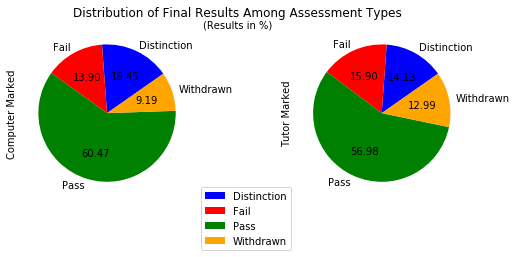

In [69]:
# assessment type and final result
results_per_asstype = tr_data_df.groupby(by = ["final_result", "assessment_type"]).count()

# plot results
plots = results_per_asstype.unstack()["id_student"].plot.pie(
    subplots = True, figsize = (8, 6), autopct = "%.2f", colors = ["blue", "red", "green", "orange"],
    pctdistance = 0.6, startangle = 35)
plots[0].get_legend().remove() # hide all legends besides one
plots[1].legend(bbox_to_anchor = (0, 0.1))

plots[0].set_ylabel("Computer Marked")
plots[1].set_ylabel("Tutor Marked")

plt.suptitle("Distribution of Final Results Among Assessment Types", y = 0.75)
plt.figtext(x = 0.5, y = 0.7, s = "(Results in %)", ha = "center")
plt.subplots_adjust(wspace = 0.6) # pull subplots apart horizontally
plt.show()

As the differences here are all below 4 percentage points and mostly between 2-3 percentage points, I will decide against using this variable in the final feature space. 

It is noteworthy that due to the earlier cleaning, we eliminated the category `Exam` from these assessment types. If we were to use this later to be one-hot-encoded feature, the validation and train set observation `Exam` would be filled with only zeros as the value isn't recognized in the train fit.

Nevertheless, the `Exam` observations won't be lost because the `weight` feature in validation and test set still entails the information of `Exam`. Exams are uniquely weighted an additional 100% on their own, so we can still make use of that information even though the train sets have declared that 100% weight as outliers due to relatively few final exams.

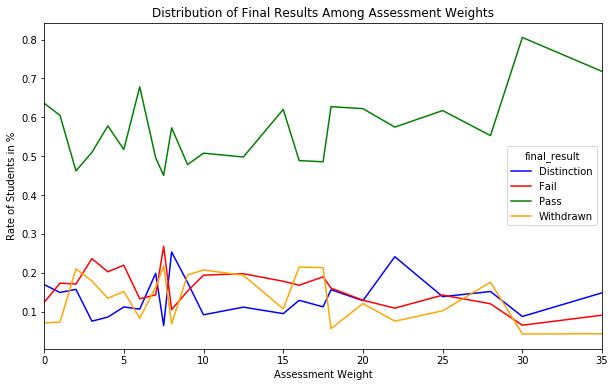

In [70]:
# weight and final result

# group the feature
results_per_weight = tr_data_df.groupby(by = ["weight", "final_result"]).count()["id_student"]

# visualize results as rates to normalize for number of students
results_per_weight_rate = pd.DataFrame(results_per_weight) / pd.DataFrame(
    results_per_weight).sum(axis = 0, level = 0)

results_per_weight_rate.unstack()["id_student"].plot.line(color = ["blue", "red", "green", "orange"],
                                                         figsize = (10, 6))
plt.title("Distribution of Final Results Among Assessment Weights")
plt.xlabel("Assessment Weight")
plt.ylabel("Rate of Students in %")
plt.show()

On the x-axis, we have each assessment weight listed here, and correspondingly on the y-axis the percentage of players finishing in each class for assessments with the specific weight.

In general, we can see that there is variation among the different assessment weights. For instance, the `Pass` rate differes in the ranges of ~45% up to ~80%. All 3 other classes vary in between the ranges of ~5% and ~25%. 

As a consequence, considering `weight` in our final feature space will positively affect the classification problem. Incorporating trends that are differing for various levels of assessment weights allows us to find patterns that are useful for correctly categorizing the observation.

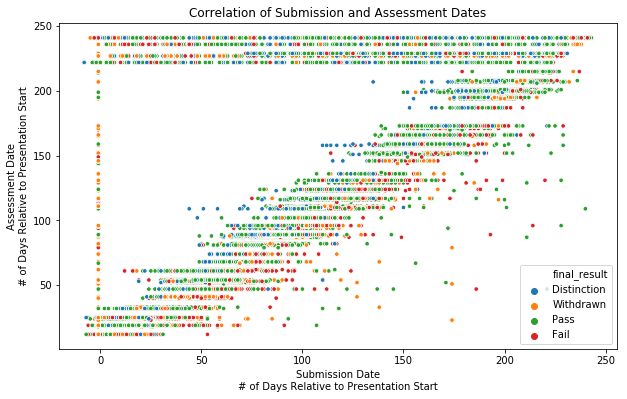

In [71]:
# submission dates and assessment dates, marked by final result
plt.figure(figsize = (10, 6))
sns.scatterplot("date_submitted", "date", hue = "final_result", data = tr_data_df,
                hue_order = ["Distinction", "Withdrawn", "Pass", "Fail"], s = 20)
plt.title("Correlation of Submission and Assessment Dates")
plt.xlabel("Submission Date\n# of Days Relative to Presentation Start")
plt.ylabel("Assessment Date\n# of Days Relative to Presentation Start")
plt.show()

Although the dates aren't completely continuously distributed, we can see a clear correlation between assessment dates and submission of those assessments. Nonetheless, there is a significant number of outliers present. For instance, a lot of exams were submitted very early (between 0 and 100 days) even though the assessment deadline was between 225 and 250 days. 

Due to the coloring we can also observe a very informative pattern: very early assessment and submission dates often lead to withdrawing of the students, marked by orange dots. Students marked blue finished with distinction, and we can see very well that they submitted their exams in strong correlation to the assessment dates but in an early time range around 20-30 days in advance. For example, there is grouping of blue-marked students for exams around 150 days on the y-axis, and from the x-axis we can see that generally submitted around day 120-130. The same pattern is recognizable with exams dated around 90-110 days on the y-axis and submissions around 60-80 days.

The middle field, which shows strong correlations between submission and assessment dates, is dominantly marked green, i.e. students who pass. This means that the majority of students submit their work closely around the deadline. Nevertheless, there are a lot of outliers which also passed exams in the top line of the graph.

The red dots indicate students who failed the module. They are grouped generally towards the back, i.e. right side of our middle field. For instance, there is a group of assessments dated around 60-70 days on the y-axis, and the submission were around 70 days or even later. The same pattern can be observed with assessments around ~150 days, and close to 200 days. Submissions by students who failed are generally around the assessment date or even later. 

Submitting an assessment late doesn't automatically mean that the student will fail the whole module as there are multiple assessments. This is indicated by all the green dots on the right side that are later submitted than their assessment day (higher date on x-axis than on y-axis indicates this phenomenon). 

As there are trends recognizable among these 2 features and the final result, these variables will positively contribute to our classification model and will thus be incorporated into all ML models.

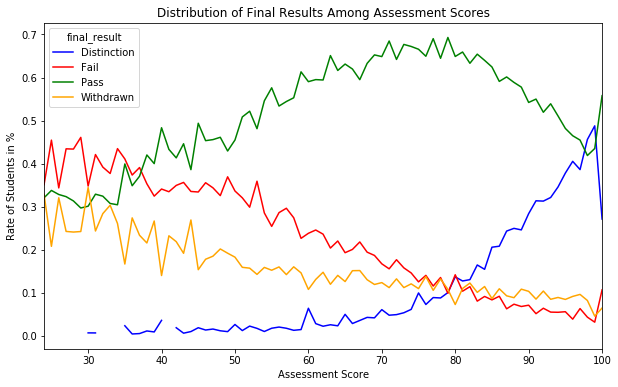

In [72]:
# score and final results

# group the feature
results_per_score = tr_data_df.groupby(by = ["score", "final_result"]).count()["id_student"]

# visualize results as rates to normalize for number of students
results_per_score_rate = pd.DataFrame(results_per_score) / pd.DataFrame(
    results_per_score).sum(axis = 0, level = 0)

results_per_score_rate.unstack()["id_student"].plot.line(color = ["blue", "red", "green", "orange"],
                                                        figsize = (10, 6))
plt.title("Distribution of Final Results Among Assessment Scores")
plt.xlabel("Assessment Score")
plt.ylabel("Rate of Students in %")
plt.show()

This visualization perfectly exemplifies how the scores of assessments during the module impact the final results.

If students finish assessments below ~40, the chace of finishing with `Distinction` isn't even consistently possible - as the blue line shows when it is partially interrupted. The higher the assessment scores get during the module, the higher the chace of finishing with distinction. The blue line rises up towards ~50% in the upper 90 ranges of scores. At around score 100, the line drops again to around 25% at the same time the `Pass` line rises abruptly. Otherwise, `Pass` starts at around 35% and also rises as the scores get higher. It starts dropping at around 80 - the same time when `Distinction` really starts to rise.

The `Fail` rate starts high at around 40% for students with assessments below score 30, and then drops towards 5% in the high 90 score ranges. The `Withdrawn` rate behaves very similarly to the fail rate but it starts a bit lower at ~32% and drops also slower towards the same ending area of ~5%. 

In the very high 97+ score ranges, we can see a rise of both withdrawing, failing, as well as passing with distinction falling. One possible explanation might be that students who have finished some assessments in the very high score ranges tend to not put as much effort in the following assessments as the feel like they know the subject very well. As a result, those assessments get classified here in the 97+ score ranges with a final result other than distinction.

We can see here very clear trends that will most certainly play a significant role in helping us classify student observations correctly. The feature will be implemented in our feature matrix.

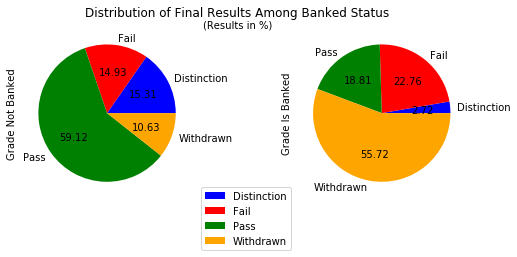

In [73]:
# is_banked and final result

# slice for banked status
results_per_banked = tr_data_df.groupby(by = ["final_result", "is_banked"]).count()["id_student"]

# plot results
plots = results_per_banked.unstack().plot.pie(
    subplots = True, figsize = (8, 6), autopct = "%.2f", colors = ["blue", "red", "green", "orange"],
    pctdistance = 0.6)
plots[0].get_legend().remove() # hide all legends besides one
plots[1].legend(bbox_to_anchor = (0, 0.1))

plots[0].set_ylabel("Grade Not Banked")
plots[1].set_ylabel("Grade Is Banked")

plt.suptitle("Distribution of Final Results Among Banked Status", y = 0.75)
plt.figtext(x = 0.5, y = 0.7, s = "(Results in %)", ha = "center")
plt.subplots_adjust(wspace = 0.6) # pull subplots apart horizontally
plt.show()

In [74]:
# get ratio of banked scors
(tr_data_df["is_banked"].value_counts() / # 1951 banked scores in absolute numbers
tr_data_df["is_banked"].value_counts().sum())

0    0.983039
1    0.016961
Name: is_banked, dtype: float64

While in total only 1.7% of assessment scores are banked, they are still almost 2,000 is absolute numbers. The observations are therefore still representative.

The change in distribution is very strong here. While non-banked scores `Pass` in 59% of cases, banked scores pass in only 19%. 

The distribution change is even more radical for `Withdrawn`: Non-banked scores only end in withdrawal in ~11% on average, whereas banked scores result in withdrawal ~56% of times. `Distinction` shrinks from 15% in non-banked observations to only ~3% is banked assessments. The failure rate also changes, but not as dramatically as our other 3 classes. `Fail` changes from 15% for non-banked scores to ~23% for banked scores.

If the differences in distributions weren't as strong as they are, I maybe would have questioned whether it is beneficial to classification to add a feature where only 1.7% of observations are in one class and all other 98.3% are in the other, but as we have ~2,000 observations available that are so distinctly different, I will keep this feature in all our sets.
___

### Feature Encoding
We will now discuss which categorical features will be one-hot-encoded, which ordinal string features need to be integer-encoded but on an ordinal scale, which continuous feature will be log-transformed, and which feature will stay as they are.

#### Features to be one-hot-encoded
* `code_module` --> categorizes the courses
* `presentation_term` --> marks whether a course is started in February or October
* `gender` --> differentiates between M and F, i.e. two categories
* `region` --> categorizes the place at which students reside; no natural order
* `studied_credits` --> the number of credit study category to which a student belongs; although it is in number format and there are differences among study volume, to me this is definitely a categorical, decision-based variable (in the sense of a student deciding which credit track to choose) without a ranking character
* `disability` --> indicates disability status; no natural order
* `date_registration` --> marks the registration date; has already been categorized, and as described earlier will now be one-hot-encoded
* `id_assessment` --> identifies the unique assessments; in our training observations (combined set), there are 182 unique assessments, which we will treat as categorical variables. The assessment ID itself does not bear any numerical value except for identification, so we will one-hot-encode each assessment
* `is_banked` --> marks whether the grade is transferred from a previous course; has no ranking, in fact, it has a clear categorical nature
* `activity_type` --> defines the type of most used learning resource used by the student; is by nature categorical and not ordered, so will be one-hot-encoded
* `num_of_prev_attempts` --> has been categorized to reflect whether the student enters the assessment in first try (category 0) or multiple try (category 1)

#### Features to be ordinally encoded
* `highest_education` --> differentiates among finished highest education coming into the course; does follow a natural order in level of degree and thus will be ordinally encoded
    * No formal qualification < Lower than A-level < A-level or equivalent < Higher education qualification < Post graduate qualification
* `age_band` --> marks the student's age group; has a natural order

#### To be log-transformed
All following continuous variables will be log-transformed with a custom function that adds a constant of 30, i.e. $\log{(30 + \text{observation})}$. This is necessary because there are multiple features which have negative values by design. For instance, students can submit assessments in `date_submitted` before presentation starts. As presentation start is day 0, these values can be negative.
* `date_submitted` --> indicates day relative to presentation start on which the assessment has been submitted
* `score` --> number of points in assessment on range from 0 to 100
* `date` --> day relative to presentation start on which assessment deadline is scheduled
* `module_presentation_length` --> course length in number of days
* `total_sites_used` --> number of sites a student used in total to study
* `total_clicks` --> number of clicks for a student in the virtual learning environment
* `avg_working_days` --> mean of days on which student was active in VLE
* `weight` --> weighting of the assessment

#### Already in correct format
* `imd_band` --> indicates the economic strength of the student's immediate living area inside the region; has a natural order, but has already been correctly encoded with integer values in 10 percentage points ranges from 5 to 95 (as a proxy for "0-10%" strings)

#### Labels
`final_result` is the column with the classification labels we are trying to predict later on. As the column is string-encoded right now, we will use sklearn's `LabelEncoder` ordinal numerical values

#### Features to be removed
* `id_student` --> ID numbers don't have numerical value in ML models, only informational value in identifying to which student the profile at hand belongs. The feature will be saved in this order in a separate variable if identification of a student is needed later on.
* `presentation_year` and `presentation_term` were needed to efficiently explore the data in the previous step. However, now they bear the same information as `code_presentation`. As there aren't any significant differences among the years, I will only use `presentation_term` to indicate the February- and October-starting modules. Therefore, `code_presentation` and `presentation_year` will be removed but stored in two variables with the current indices if needed later on.
* `assessment_type` will also be dropped as there aren't enough differentiation factors 

In [75]:
# save features that will be dropped later on
tr_data_df_dropped = tr_data_df[["id_student", "presentation_year", "code_presentation",
                                 "assessment_type"]].copy()
val_data_df_dropped = val_data_df[["id_student", "presentation_year", "code_presentation",
                                  "assessment_type"]].copy()
te_data_df_dropped = te_data_df[["id_student", "presentation_year", "code_presentation",
                                "assessment_type"]].copy()

tr_data_df_b_dropped = tr_data_df_b[["id_student", "presentation_year", "code_presentation",
                                    "assessment_type"]].copy()
val_data_df_b_dropped = val_data_df_b[["id_student", "presentation_year", "code_presentation",
                                      "assessment_type"]].copy()
te_data_df_b_dropped = te_data_df_b[["id_student", "presentation_year", "code_presentation",
                                    "assessment_type"]].copy()

tr_data_df_j_dropped = tr_data_df_j[["id_student", "presentation_year", "code_presentation",
                                    "assessment_type"]].copy()
val_data_df_j_dropped = val_data_df_j[["id_student", "presentation_year", "code_presentation",
                                      "assessment_type"]].copy()
te_data_df_j_dropped = te_data_df_j[["id_student", "presentation_year", "code_presentation",
                                    "assessment_type"]].copy()

tr_data_df_dropped.to_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/tr_data_df_dropped.csv",
                         index = False)
val_data_df_dropped.to_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/val_data_df_dropped.csv",
                         index = False)
te_data_df_dropped.to_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/te_data_df_dropped.csv",
                         index = False)

tr_data_df_b_dropped.to_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/tr_data_df_dropped.csv",
                         index = False)
val_data_df_b_dropped.to_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/val_data_df_b_dropped.csv",
                         index = False)
te_data_df_b_dropped.to_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/te_data_df_b_dropped.csv",
                         index = False)

tr_data_df_j_dropped.to_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/tr_data_df_dropped.csv",
                         index = False)
val_data_df_j_dropped.to_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/val_data_df_j_dropped.csv",
                         index = False)
te_data_df_j_dropped.to_csv("/Users/Ingo/Python Files/Capstone Project/data_dfs/te_data_df_j_dropped.csv",
                         index = False)


# get label in separate variable
y_tr = tr_data_df["final_result"].copy()
y_val = val_data_df["final_result"].copy()
y_te = te_data_df["final_result"].copy()

y_tr_b = tr_data_df_b["final_result"].copy()
y_val_b = val_data_df_b["final_result"].copy()
y_te_b = te_data_df_b["final_result"].copy()

y_tr_j = tr_data_df_j["final_result"].copy()
y_val_j = val_data_df_j["final_result"].copy()
y_te_j = te_data_df_j["final_result"].copy()

# drop not needed features
tr_data_df.drop(["id_student", "presentation_year",  "code_presentation", "assessment_type",
                 "final_result"], axis = 1, inplace = True)
val_data_df.drop(["id_student", "presentation_year",  "code_presentation", "assessment_type",
                 "final_result"], axis = 1, inplace = True)
te_data_df.drop(["id_student", "presentation_year",  "code_presentation", "assessment_type",
                 "final_result"], axis = 1, inplace = True)

tr_data_df_b.drop(["id_student", "presentation_year",  "code_presentation", "assessment_type",
                 "final_result"], axis = 1, inplace = True)
val_data_df_b.drop(["id_student", "presentation_year",  "code_presentation", "assessment_type",
                 "final_result"], axis = 1, inplace = True)
te_data_df_b.drop(["id_student", "presentation_year",  "code_presentation", "assessment_type",
                 "final_result"], axis = 1, inplace = True)

tr_data_df_j.drop(["id_student", "presentation_year",  "code_presentation", "assessment_type",
                 "final_result"], axis = 1, inplace = True)
val_data_df_j.drop(["id_student", "presentation_year",  "code_presentation", "assessment_type",
                 "final_result"], axis = 1, inplace = True)
te_data_df_j.drop(["id_student", "presentation_year",  "code_presentation", "assessment_type",
                 "final_result"], axis = 1, inplace = True)

In [76]:
# get features to be one-hot-encoded in list
ohe_features = ["code_module", "presentation_term", "gender", "region", "studied_credits", "disability",
               "date_registration", "id_assessment", "is_banked", "activity_type", "num_of_prev_attempts"]

# get features to be ordinally encoded in list
ord_features = ["highest_education", "age_band"]

# continuous features are already grouped with variable cont_features

# group all other features
correct_features = ["imd_band"]

In [77]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# define log-transformation function
def log30p(obs):
    return np.log(30 + obs) # add constant of 30 to every observation

# create function transformer object
log_transform = FunctionTransformer(func = log30p, validate = False)

# create OHE object, ignore unknown values in val/test set
ohe = OneHotEncoder(handle_unknown = "ignore", sparse = False, dtype = np.float32)

# define categories and values for ordinal encoder, otherwise values will be encoded in different order
education = ["No Formal quals", "Lower Than A Level", "A Level or Equivalent", "HE Qualification",
             "Post Graduate Qualification"]
age = ["0-35", "35-55", "55<="]

# create OrdinalEncoder object
oenc = OrdinalEncoder(categories = [education, age])

# create LabelEncoder object
lblenc = LabelEncoder()

# fit and transform every label column
lblenc.fit(["Fail", "Withdrawn", "Pass", "Distinction"]) # set order i.e. fail --> 0, distinc = 3

y_tr = lblenc.transform(y_tr)
y_val = lblenc.transform(y_val)
y_te = lblenc.transform(y_te)

y_tr_b = lblenc.transform(y_tr_b)
y_val_b = lblenc.transform(y_val_b)
y_te_b = lblenc.transform(y_te_b)

y_tr_j = lblenc.transform(y_tr_j)
y_val_j = lblenc.transform(y_val_j)
y_te_j = lblenc.transform(y_te_j)

In [78]:
# create column transformer
preprocessor = ColumnTransformer([
    ("ohe", ohe, ohe_features), # one-hot-encoder in format: ("name", transformer, feature names)
    ("ord_enc", oenc, ord_features), # ordinal feature encoding
    ("log", log_transform, cont_features), # log-transform continuous features
], remainder = "passthrough") # append all other features at the end


# transform all 9 sets, fit on training data, transform all sets based on training fit
X_tr = preprocessor.fit_transform(tr_data_df)
X_val = preprocessor.transform(val_data_df)
X_te = preprocessor.transform(te_data_df)

# ______________________________________
# for the visualization of the deicsion tree, we need these feature names now
# otherwise we need to reload and transform everything

# get feature names on OHE columns
ohe_feature_names = preprocessor.named_transformers_["ohe"].get_feature_names()

# create list of all column names in encoded df
column_names = list(ohe_feature_names) + ord_features + cont_features + correct_features
print("number of named columns:", len(column_names)) # same number as columns in X_tr

number of named columns: 236


In [79]:
# continue transforming
X_tr_b = preprocessor.fit_transform(tr_data_df_b)
X_val_b = preprocessor.transform(val_data_df_b)
X_te_b = preprocessor.transform(te_data_df_b)

X_tr_j = preprocessor.fit_transform(tr_data_df_j)
X_val_j = preprocessor.transform(val_data_df_j)
X_te_j = preprocessor.transform(te_data_df_j)

# get shapes of encoded features and labels
print("X_tr shape = {}, y_tr = {}".format(X_tr.shape, y_tr.shape))
print("X_val shape = {}, y_val = {}".format(X_val.shape, y_val.shape))
print("X_te shape = {}, y_te = {}".format(X_te.shape, y_te.shape))

print("X_tr_b shape = {}, y_tr_b = {}".format(X_tr_b.shape, y_tr_b.shape))
print("X_val_b shape = {}, y_val_b = {}".format(X_val_b.shape, y_val_b.shape))
print("X_te_b shape = {}, y_te_b = {}".format(X_te_b.shape, y_te_b.shape))

print("X_tr_j shape = {}, y_tr_j = {}".format(X_tr_j.shape, y_tr_j.shape))
print("X_val_j shape = {}, y_val_j = {}".format(X_val_j.shape, y_val_j.shape))
print("X_te_j shape = {}, y_te_j = {}".format(X_te_j.shape, y_te_j.shape))

X_tr shape = (115027, 236), y_tr = (115027,)
X_val shape = (41424, 236), y_val = (41424,)
X_te shape = (41378, 236), y_te = (41378,)
X_tr_b shape = (44295, 138), y_tr_b = (44295,)
X_val_b shape = (15387, 138), y_val_b = (15387,)
X_te_b shape = (15871, 138), y_te_b = (15871,)
X_tr_j shape = (62447, 150), y_tr_j = (62447,)
X_val_j shape = (22864, 150), y_val_j = (22864,)
X_te_j shape = (22738, 150), y_te_j = (22738,)


Due to splitting among a combined/B/J set, there could be different counts of unique values in the various columns. As a consequence, one-hot-encoding could create varying numbers of columns in our input matrices. In this case, the column numbers are still the same, but we see after the next step that variations are possible.

In [80]:
# add columns of ones to find linear combinations
# val and test set only need col of 1 for correct deletion of train set's dependent columns
X1_tr = np.c_[np.ones(shape = X_tr.shape[0]), X_tr]
print("matrix rank of X1_tr should be 237 (incl. col of ones), test:", np.linalg.matrix_rank(X1_tr))
X1_val = np.c_[np.ones(shape = X_val.shape[0]), X_val]
X1_te = np.c_[np.ones(shape = X_te.shape[0]), X_te]

X1_tr_b = np.c_[np.ones(shape = X_tr_b.shape[0]), X_tr_b]
print("matrix rank of X1_tr_b should be 139 (incl. col of ones), test:", np.linalg.matrix_rank(X1_tr_b))
X1_val_b = np.c_[np.ones(shape = X_val_b.shape[0]), X_val_b]
X1_te_b = np.c_[np.ones(shape = X_te_b.shape[0]), X_te_b]

X1_tr_j = np.c_[np.ones(shape = X_tr_j.shape[0]), X_tr_j]
print("matrix rank of X1_tr_j should be 151 (incl. col of ones), test:", np.linalg.matrix_rank(X1_tr_j))
X1_val_j = np.c_[np.ones(shape = X_val_j.shape[0]), X_val_j]
X1_te_j = np.c_[np.ones(shape = X_te_j.shape[0]), X_te_j]

# check condition number
print("X1_tr_cond number should be relatively low, test:", np.linalg.cond(X1_tr))
print("X1_tr_cond_b number should be relatively low, test:", np.linalg.cond(X1_tr_b))
print("X1_tr_cond_j number should be relatively low, test:", np.linalg.cond(X1_tr_j))

matrix rank of X1_tr should be 237 (incl. col of ones), test: 224
matrix rank of X1_tr_b should be 139 (incl. col of ones), test: 126
matrix rank of X1_tr_j should be 151 (incl. col of ones), test: 138
X1_tr_cond number should be relatively low, test: 1.1489936191372883e+18
X1_tr_cond_b number should be relatively low, test: 1.7967018212618534e+18
X1_tr_cond_j number should be relatively low, test: 8.476654502933235e+17


We can see that all of our matrices have both linear combinations in them as well as an extremely high condition number due to nearly collinear features. 

This means that we have to find all columns that create linear combinations and remove them. Otherwise, our results would be numerically unstable. As a consequence, small changes in input data could result in massive changes of our output because our coefficients aren't robust enough.

I expect that the condition number will drop significantly as soon as the linear combinations are removed, however, I don't think that the condition number will drop so low that regularization won't be necessary. With over 100 columns, nearly collinear features are generally present, hence, all our models will require regularization tuning.

In [81]:
# finding linear dependent features

X1_tr_dependent_cols = [] # append cols to be dropped here
X1_tr_dependent_cols_b = []
X1_tr_dependent_cols_j = []

# create list of matrices and lists to append to
matrix_list = [X1_tr, X1_tr_b, X1_tr_j]
append_list = [X1_tr_dependent_cols, X1_tr_dependent_cols_b, X1_tr_dependent_cols_j]

# create list of indices based on number of columns
column_list = [np.arange(1, 236), np.arange(1, 138), np.arange(1, 150)] # combined / B / J term


# iterate through all matrices and append results in respective list
for idx in np.arange(3):
    # index our lists
    mtrx = matrix_list[idx]
    lst = append_list[idx]
    clm = column_list[idx]
    
    # iterate through every column -1, the 1 is added in loop because 0 is starting point
    for col in clm:
        
        # calculate matrix rank with "previous" number of columns
        # number of columns gets bigger each iteration
        previous_matrix_rank = np.linalg.matrix_rank(mtrx[:, :col])
        
        # calculate matrix rank of with "additional" number of columns
        current_matrix_rank = np.linalg.matrix_rank(mtrx[:, :col+1])
        
        # check whether the two ranks stayed the same despite one more col in array
        # if yes: the last added column creates dependency
        # if no: all columns until now are linearly independent
        if previous_matrix_rank == current_matrix_rank:
            lst.append(col) # append the col that creates dependency

Now that we have all dependent columns for each set in lists, we can drop those columns and re-calculate the matrix rank and condition numbers.

In [82]:
# drop all dependent cols from X1_xxx to have correct indexing

X1_tr = np.delete(X1_tr, X1_tr_dependent_cols, axis = 1)
X1_val = np.delete(X1_val, X1_tr_dependent_cols, axis = 1)
X1_te = np.delete(X1_te, X1_tr_dependent_cols, axis = 1)

X1_tr_b = np.delete(X1_tr_b, X1_tr_dependent_cols_b, axis = 1)
X1_val_b = np.delete(X1_val_b, X1_tr_dependent_cols_b, axis = 1)
X1_te_b = np.delete(X1_te_b, X1_tr_dependent_cols_b, axis = 1)

X1_tr_j = np.delete(X1_tr_j, X1_tr_dependent_cols_j, axis = 1)
X1_val_j = np.delete(X1_val_j, X1_tr_dependent_cols_j, axis = 1)
X1_te_j = np.delete(X1_te_j, X1_tr_dependent_cols_j, axis = 1)

# check ranks again
print("matrix rank of X1_tr should be 224 (incl. col of ones), test:", np.linalg.matrix_rank(X1_tr))
print("matrix rank of X1_tr_b should be 126 (incl. col of ones), test:", np.linalg.matrix_rank(X1_tr_b))
print("matrix rank of X1_tr_j should be 138 (incl. col of ones), test:", np.linalg.matrix_rank(X1_tr_j))

# check condition number again
print("X1_tr_cond number should be relatively low, test:", np.linalg.cond(X1_tr))
print("X1_tr_cond_b number should be relatively low, test:", np.linalg.cond(X1_tr_b))
print("X1_tr_cond_j number should be relatively low, test:", np.linalg.cond(X1_tr_j))

matrix rank of X1_tr should be 224 (incl. col of ones), test: 224
matrix rank of X1_tr_b should be 126 (incl. col of ones), test: 126
matrix rank of X1_tr_j should be 138 (incl. col of ones), test: 138
X1_tr_cond number should be relatively low, test: 105380.51151591394
X1_tr_cond_b number should be relatively low, test: 190127.32211750897
X1_tr_cond_j number should be relatively low, test: 239121.72819467852


We can clearly see the results of dropping linearly dependent columns: Our condition number dropped from e.g. $1.14 * 10^{18}$ in the `X_tr` set to "only" $105,380$. Our model will therefore be much more stable, meaning that small changes in input data will not result in drastic output changes. 

A condition number of $105,380$ is still high, which means that we still need to make use of regularization techniques. 
___

In [83]:
# for the decision tree visualization, we need to drop these columns from the ohe_feature_names, too
# subtract 1 of every indices because there is no column of ones at the beginning
names_to_drop = np.array(X1_tr_dependent_cols) - 1

arr = np.array(column_names) # convert list to array
column_names_cleaned = np.delete(arr, names_to_drop) # drop dependent feature names

# save the array to reload in decision tree set
np.savez("/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/column_names_cleaned.npz",
        features = column_names_cleaned, labels = None)

___

In [84]:
# drop all columns of ones
X_tr = np.delete(X1_tr, 0, axis = 1)
X_val = np.delete(X1_val, 0, axis = 1)
X_te = np.delete(X1_te, 0, axis = 1)

X_tr_b = np.delete(X1_tr_b, 0, axis = 1)
X_val_b = np.delete(X1_val_b, 0, axis = 1)
X_te_b = np.delete(X1_te_b, 0, axis = 1)

X_tr_j = np.delete(X1_tr_j, 0, axis = 1)
X_val_j = np.delete(X1_val_j, 0, axis = 1)
X_te_j = np.delete(X1_te_j, 0, axis = 1)

# final shapes (without column of ones)
print("X_tr final shape = {}".format(X_tr.shape))
print("X_val final shape = {}".format(X_val.shape))
print("X_te final shape = {}".format(X_te.shape))

print("X_tr_b final shape = {}".format(X_tr_b.shape))
print("X_val_b final shape = {}".format(X_val_b.shape))
print("X_te_b final shape = {}".format(X_te_b.shape))

print("X_tr_j final shape = {}".format(X_tr_j.shape))
print("X_val_j final shape = {}".format(X_val_j.shape))
print("X_te_j final shape = {}".format(X_te_j.shape))

X_tr final shape = (115027, 223)
X_val final shape = (41424, 223)
X_te final shape = (41378, 223)
X_tr_b final shape = (44295, 125)
X_val_b final shape = (15387, 125)
X_te_b final shape = (15871, 125)
X_tr_j final shape = (62447, 137)
X_val_j final shape = (22864, 137)
X_te_j final shape = (22738, 137)


In [85]:
# save these preprocessed dfs
np.savez("/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/train_set_preprocessed.npz",
        features = X_tr, labels = y_tr)
np.savez("/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/val_set_preprocessed.npz",
         features = X_val, labels = y_val)
np.savez("/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/test_set_preprocessed",
        features = X_te, labels = y_te)

np.savez("/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/train_set_preprocessed_b",
        features = X_tr_b, labels = y_tr_b)
np.savez("/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/val_set_preprocessed_b",
        features = X_val_b, labels = y_val_b)
np.savez("/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/test_set_preprocessed_b",
        features = X_te_b, labels = y_te_b)

np.savez("/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/train_set_preprocessed_j",
        features = X_tr_j, labels = y_tr_j)
np.savez("/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/val_set_preprocessed_j",
        features = X_val_j, labels = y_val_j)
np.savez("/Users/Ingo/Python Files/Capstone Project/preprocessed_dfs/test_set_preprocessed_j",
        features = X_te_j, labels = y_te_j)